Produces a dataset with processed and cleaned latent heat flux measurements.
Processing steps are described in Schwat et al., 2024.

Three versions of the latent heat flux measurements are included in the output/saved dataset:
* `w_h2o__3m_c`
    * 20Hz qc steps (flagged measurements removed, despiked) and 30min qc steps applied (30min fluxes with >25% 20hz measurements flagged removed, plausibility limits applied)
* `w_h2o__3m_c_raw`
    * 20Hz qc steps only (see above)
* `w_h2o__3m_c_gapfill`
    * 20Hz qc steps and 30min qc steps applied (see above), plus the gaps are filled using mean-diurnal gap filling method with 7 day window


In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units
import metpy.constants
import pint_pandas
import pint_xarray
import xarray as xr
import os
import itertools

from tqdm import tqdm
from joblib import Parallel, delayed

from metpy.constants import density_water

# Inputs

In [2]:
ls /Users/elischwat/Development/data/sublimationofsnow/ | grep planar

monthly_planar_fits.csv
monthly_planar_fits_10sectors.csv
monthly_planar_fits_archive.csv
monthly_planar_fits_oneplane.csv
planar_fit_10sector_processed_30min_despiked_q7/
planar_fit_nosector_processed_30min_despiked_q7/
planar_fit_processed/
planar_fit_processed_30min/
planar_fit_processed_30min_archive/
planar_fit_processed_30min_despiked_q3.5/
planar_fit_processed_30min_despiked_q7/
planar_fit_processed_5min/
planar_fit_processed_oneplane_5min/
weekly_planar_fits.csv


In [3]:
ls /Users/elischwat/Development/data/sublimationofsnow/ | grep double 

double_rotated_30min_despiked_q7/


In [4]:
sos_data_dir = '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/'

# Choices:
planar_fitted_dir = "/Users/elischwat/Development/data/sublimationofsnow/planar_fit_10sector_processed_30min_despiked_q7"
filtering_str = 'q7'
FILTER_SNOWFALL = False
snowfall_mask_file = "/Users/elischwat/Development/data/sublimationofsnow/precipitation_masks/w23_precipitation_mask_0_mm.csv"
snowfall_mask_str = None
PERCENTAGE_DIAG = 9000

# Constants
PLANAR_FIT = True
start_date = '20221101'
end_date = '20230619'
# STUDY_PERIOD_START_DATE = '20221130'
# STUDY_PERIOD_END_DATE = '20230508'
STUDY_PERIOD_START_DATE = '20221101'
STUDY_PERIOD_END_DATE = '20230619'
DATE_FORMAT_STR = '%Y%m%d'
# Threshold number of 20hz samples in a 5 minute average determining if the value
# is replaced with NaN
datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

In [5]:
# Separate out the eddy covariance measurement variable names because they are very repetitive
ec_measurement_suffixes = [
    '1m_ue',    '2m_ue',    '3m_ue',    '10m_ue', 
    '1m_d',     '2m_d',     '3m_d',     '10m_d',
    '1m_uw',    '2m_uw',    '2_5m_uw',  '3m_uw',    '10m_uw', 
    '1m_c',     '2m_c',     '3m_c',     '5m_c',     '10m_c',    '15m_c',    '20m_c'
]

sonic_measurement_prefixes = [
    'u_', 'v_', 'w_', 'tc_', 'spd_', 'dir_', 
    'u_u__', 'v_v__', 'w_w__', 'tc_tc__', 
    'u_w__', 'v_w__', 'u_v__', 
    'u_tc__', 'v_tc__', 'w_tc__', 
    'u_u_u__', 'v_v_v__', 'w_w_w__', 
    'tc_tc_tc__', 
]
irga_measurement_prefixes = [
    'h2o_', 'h2o_h2o__', 'h2o_h2o_h2o__', 'co2_', 'co2_co2__', 'co2_co2_co2__', 
]
sonic_plus_irga_measurement_prefixes = [
    'u_h2o__', 'v_h2o__', 'w_h2o__', 'u_co2__', 'v_co2__', 'w_co2__', 
]
ec_measurement_prefixes = sonic_measurement_prefixes + irga_measurement_prefixes + sonic_plus_irga_measurement_prefixes

ec_variable_names = [
    (prefix + suffix) for prefix in ec_measurement_prefixes for suffix in ec_measurement_suffixes
]

counts_vars = ['counts_' + suffix for suffix in ec_measurement_suffixes]
counts_1_vars = ['counts_' + suffix + '_1' for suffix in ec_measurement_suffixes]
counts_2_vars = ['counts_' + suffix + '_2' for suffix in ec_measurement_suffixes]
irgadiag_vars = ['irgadiag_' + suffix for suffix in ec_measurement_suffixes]
ldiag_vars = ['ldiag_' + suffix for suffix in ec_measurement_suffixes]

diagnostic_variable_names = counts_vars + counts_1_vars + counts_2_vars + irgadiag_vars + ldiag_vars

VARIABLE_NAMES = ec_variable_names + diagnostic_variable_names + [
    # Temperature & Relative Humidity Array 
    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward/Upward Facing Longwave Radiometers
    'Rpile_out_9m_d','Tcase_out_9m_d',    
    'Rpile_in_9m_d', 'Tcase_in_9m_d',
    'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d', 'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',

    # Ground heat flux
    'Gsoil_d',
]

# Open SoS datasets

In [6]:
all_file_paths = [
    os.path.join(
        sos_data_dir,
        f'isfs_sos_qc_geo_tiltcor_5min_{date}.nc'
    ) for date in datelist
]
datasets = []
for file in all_file_paths:
    ds = xr.open_dataset(file)
    # this ensures we don't access variables that aren't in this dataset, which would throw an error
    ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
    datasets.append(ds_new)

In [7]:
all_file_paths

['/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221101.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221102.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221103.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221104.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221105.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221106.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/isfs_sos_qc_geo_tiltcor_5min_20221107.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltc

In [8]:
sos_ds = xr.concat(datasets, dim='time')

Ensure time index is evenly spaced by filling in any missing timestamps

In [9]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

# CHECKPOINT

In [10]:
sos_ds.to_netcdf("sos_ds_temp_storage_30min_straightup.cdf")

In [11]:
sos_ds = xr.open_dataset("sos_ds_temp_storage_30min_straightup.cdf")

In [12]:
src = sos_ds[[
    'T_1m_c',
    'T_2m_c',
    'T_3m_c',
    'T_5m_c',
    'T_10m_c',
    'T_15m_c',
    'T_20m_c',
]].to_dataframe()
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(tidy._height_from_variable_name)
src['measurement'] = src['variable'].apply(tidy._measurement_from_variable_name)
src['tower'] = src['variable'].apply(tidy._tower_from_variable_name)
src

,variable,value,height,measurement,tower
time,,,,,
2022-11-01 00:02:30,T_1m_c,0.062843,1.0,temperature,c
2022-11-01 00:07:30,T_1m_c,0.175545,1.0,temperature,c
2022-11-01 00:12:30,T_1m_c,0.229297,1.0,temperature,c
2022-11-01 00:17:30,T_1m_c,0.398593,1.0,temperature,c
2022-11-01 00:22:30,T_1m_c,0.377997,1.0,temperature,c
...,...,...,...,...,...
2023-06-19 23:37:30,T_20m_c,18.726437,20.0,temperature,c
2023-06-19 23:42:30,T_20m_c,18.643732,20.0,temperature,c
2023-06-19 23:47:30,T_20m_c,18.711649,20.0,temperature,c


In [13]:
alt.Chart(src.loc['20221201 15'].reset_index()).mark_line(point=True).encode(
    alt.X('value:Q').title('Temperature (˚C)'),
    alt.Y('height:Q').title('height (m)'),
    alt.Facet('time:T', columns=4).header(format='%H:%M:%S'),
    order = 'height'
).properties(width=100, height=100).display(renderer='svg')

alt.Chart(...)

# Replace flag variables with my calculated aggregated flags
(sonic anemometer and irgason flags)

In [14]:
flag_counts_df = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast_flagcounts").loc[start_date: end_date]
assert all(sos_ds.time == flag_counts_df.index)

In [15]:
irga_vars = [
    'irgadiag_10m_c',	 'irgadiag_10m_d',	 'irgadiag_10m_ue',	 'irgadiag_10m_uw',	 'irgadiag_15m_c',	 'irgadiag_1m_c',	 'irgadiag_1m_d',	 'irgadiag_1m_ue',	 
    'irgadiag_1m_uw',	 'irgadiag_20m_c',	 'irgadiag_2m_c',	 'irgadiag_3m_c',	 'irgadiag_3m_d',	 'irgadiag_3m_ue',	 'irgadiag_3m_uw',	 'irgadiag_5m_c',	
]

ldiag_vars = [
    'ldiag_10m_c', 'ldiag_10m_d', 'ldiag_10m_ue', 'ldiag_10m_uw', 'ldiag_15m_c', 'ldiag_1m_c', 'ldiag_1m_d', 'ldiag_1m_ue', 
    'ldiag_1m_uw', 'ldiag_20m_c', 'ldiag_2m_c', 'ldiag_3m_c', 'ldiag_3m_d', 'ldiag_3m_ue', 'ldiag_3m_uw', 'ldiag_5m_c',
]

for var in irga_vars + ldiag_vars:
    sos_ds[var] = flag_counts_df[var]

# Resample dataset

## Define dictionary defining the resampling function to use for each variable

Covariances are resampled according to the rules of **Reynold averaging** (https://www.eol.ucar.edu/content/combining-short-term-moments-longer-time-periods).

Meteorological and turbulence measurements (other than covariances) are resampled using the **mean**.

EC count variables are **summed**.

In [16]:
data_vars_processing_dict = {
    'reynolds_average': [
        'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_co2__1m_uw', 'u_h2o__1m_uw',  'v_co2__1m_uw', 'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_co2__1m_uw', 'w_h2o__1m_uw',
        'u_u__2m_uw',    'v_v__2m_uw',    'w_w__2m_uw',    'u_w__2m_uw',    'v_w__2m_uw',  'u_tc__2m_uw',  'v_tc__2m_uw',   'u_co2__2m_uw', 'u_h2o__2m_uw',  'v_co2__2m_uw', 'v_h2o__2m_uw',   'w_tc__2m_uw',   'w_co2__2m_uw', 'w_h2o__2m_uw',
        'u_u__2_5m_uw', 'v_v__2_5m_uw',   'w_w__2_5m_uw',  'u_w__2_5m_uw',  'v_w__2_5m_uw','u_tc__2_5m_uw','v_tc__2_5m_uw', 'u_co2__2_5m_uw', 'u_h2o__2_5m_uw','v_h2o__2_5m_uw', 'w_tc__2_5m_uw', 'w_co2__2_5m_uw', 'w_h2o__2_5m_uw',
        'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_co2__3m_uw', 'u_h2o__3m_uw',  'v_co2__3m_uw', 'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_co2__3m_uw', 'w_h2o__3m_uw',
        'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_co2__10m_uw', 'u_h2o__10m_uw', 'v_co2__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_co2__10m_uw', 'w_h2o__10m_uw',
        'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_co2__1m_ue', 'u_h2o__1m_ue',  'v_co2__1m_ue', 'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_co2__1m_ue', 'w_h2o__1m_ue',
        'u_u__2m_ue',    'v_v__2m_ue',    'w_w__2m_ue',    'u_w__2m_ue',    'v_w__2m_ue',  'u_tc__2m_ue',  'v_tc__2m_ue',   'u_co2__2m_ue', 'u_h2o__2m_ue',  'v_co2__2m_ue', 'v_h2o__2m_ue',   'w_tc__2m_ue',   'w_co2__2m_ue', 'w_h2o__2m_ue',
        'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_co2__3m_ue', 'u_h2o__3m_ue',  'v_co2__3m_ue', 'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_co2__3m_ue', 'w_h2o__3m_ue',
        'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_co2__10m_ue', 'u_h2o__10m_ue', 'v_co2__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_co2__10m_ue', 'w_h2o__10m_ue',
        'u_u__1m_d',     'v_v__1m_d',     'w_w__1m_d',     'u_w__1m_d',     'v_w__1m_d',   'u_tc__1m_d',   'v_tc__1m_d',    'u_co2__1m_d', 'u_h2o__1m_d',   'v_co2__1m_d', 'v_h2o__1m_d',    'w_tc__1m_d',    'w_co2__1m_d', 'w_h2o__1m_d',
        'u_u__2m_d',     'v_v__2m_d',     'w_w__2m_d',     'u_w__2m_d',     'v_w__2m_d',   'u_tc__2m_d',   'v_tc__2m_d',    'u_co2__2m_d', 'u_h2o__2m_d',   'v_co2__2m_d', 'v_h2o__2m_d',    'w_tc__2m_d',    'w_co2__2m_d', 'w_h2o__2m_d',
        'u_u__3m_d',     'v_v__3m_d',     'w_w__3m_d',     'u_w__3m_d',     'v_w__3m_d',   'u_tc__3m_d',   'v_tc__3m_d',    'u_co2__3m_d', 'u_h2o__3m_d',   'v_co2__3m_d', 'v_h2o__3m_d',    'w_tc__3m_d',    'w_co2__3m_d', 'w_h2o__3m_d',
        'u_u__10m_d',    'v_v__10m_d',    'w_w__10m_d',    'u_w__10m_d',    'v_w__10m_d',  'u_tc__10m_d',  'v_tc__10m_d',   'u_co2__10m_d', 'u_h2o__10m_d',  'v_co2__10m_d', 'v_h2o__10m_d',   'w_tc__10m_d',   'w_co2__10m_d', 'w_h2o__10m_d',
        'u_u__1m_c',     'v_v__1m_c',     'w_w__1m_c',     'u_w__1m_c',     'v_w__1m_c',   'u_tc__1m_c',   'v_tc__1m_c',    'u_co2__1m_c', 'u_h2o__1m_c',   'v_co2__1m_c', 'v_h2o__1m_c',    'w_tc__1m_c',    'w_co2__1m_c', 'w_h2o__1m_c',
        'u_u__2m_c',     'v_v__2m_c',     'w_w__2m_c',     'u_w__2m_c',     'v_w__2m_c',   'u_tc__2m_c',   'v_tc__2m_c',    'u_co2__2m_c', 'u_h2o__2m_c',   'v_co2__2m_c', 'v_h2o__2m_c',    'w_tc__2m_c',    'w_co2__2m_c', 'w_h2o__2m_c',
        'u_u__3m_c',     'v_v__3m_c',     'w_w__3m_c',     'u_w__3m_c',     'v_w__3m_c',   'u_tc__3m_c',   'v_tc__3m_c',    'u_co2__3m_c', 'u_h2o__3m_c',   'v_co2__3m_c', 'v_h2o__3m_c',    'w_tc__3m_c',    'w_co2__3m_c', 'w_h2o__3m_c',
        'u_u__5m_c',     'v_v__5m_c',     'w_w__5m_c',     'u_w__5m_c',     'v_w__5m_c',   'u_tc__5m_c',   'v_tc__5m_c',    'u_co2__5m_c', 'u_h2o__5m_c',   'v_co2__5m_c', 'v_h2o__5m_c',    'w_tc__5m_c',    'w_co2__5m_c', 'w_h2o__5m_c',
        'u_u__10m_c',    'v_v__10m_c',    'w_w__10m_c',    'u_w__10m_c',    'v_w__10m_c',  'u_tc__10m_c',  'v_tc__10m_c',   'u_co2__10m_c', 'u_h2o__10m_c',  'v_co2__10m_c', 'v_h2o__10m_c',   'w_tc__10m_c',   'w_co2__10m_c', 'w_h2o__10m_c',
        'u_u__15m_c',    'v_v__15m_c',    'w_w__15m_c',    'u_w__15m_c',    'v_w__15m_c',  'u_tc__15m_c',  'v_tc__15m_c',   'u_co2__15m_c', 'u_h2o__15m_c',  'v_co2__15m_c', 'v_h2o__15m_c',   'w_tc__15m_c',   'w_co2__15m_c', 'w_h2o__15m_c',
        'u_u__20m_c',    'v_v__20m_c',    'w_w__20m_c',    'u_w__20m_c',    'v_w__20m_c',  'u_tc__20m_c',  'v_tc__20m_c',   'u_co2__20m_c', 'u_h2o__20m_c',  'v_co2__20m_c', 'v_h2o__20m_c',   'w_tc__20m_c',   'w_co2__20m_c', 'w_h2o__20m_c',
    ],
    'average': [
        # Sonic anemometer data
        'co2_1m_uw', 'h2o_1m_uw' ,       'tc_1m_uw',     'spd_1m_uw',    'u_1m_uw',  'v_1m_uw',   'w_1m_uw',  
        'co2_3m_uw', 'h2o_3m_uw' ,       'tc_3m_uw',     'spd_3m_uw',    'u_3m_uw',  'v_3m_uw',   'w_3m_uw',  
        'co2_10m_uw', 'h2o_10m_uw' ,      'tc_10m_uw',    'spd_10m_uw',   'u_10m_uw', 'v_10m_uw',  'w_10m_uw',  
        'co2_1m_ue', 'h2o_1m_ue' ,       'tc_1m_ue',     'spd_1m_ue',    'u_1m_ue',  'v_1m_ue',   'w_1m_ue',  
        'co2_3m_ue', 'h2o_3m_ue' ,       'tc_3m_ue',     'spd_3m_ue',    'u_3m_ue',  'v_3m_ue',   'w_3m_ue',  
        'co2_10m_ue', 'h2o_10m_ue' ,      'tc_10m_ue',    'spd_10m_ue',   'u_10m_ue', 'v_10m_ue',  'w_10m_ue',  
        'co2_1m_d', 'h2o_1m_d' ,        'tc_1m_d',      'spd_1m_d',     'u_1m_d',   'v_1m_d',    'w_1m_d',  
        'co2_3m_d', 'h2o_3m_d' ,        'tc_3m_d',      'spd_3m_d',     'u_3m_d',   'v_3m_d',    'w_3m_d',  
        'co2_10m_d', 'h2o_10m_d' ,       'tc_10m_d',     'spd_10m_d',    'u_10m_d',  'v_10m_d',   'w_10m_d',  
        'co2_1m_c', 'h2o_1m_c' ,        'tc_1m_c',      'spd_1m_c',     'u_1m_c',   'v_1m_c',    'w_1m_c',  
        'co2_2m_c', 'h2o_2m_c' ,        'tc_2m_c',      'spd_2m_c',     'u_2m_c',   'v_2m_c',    'w_2m_c',  
        'co2_3m_c', 'h2o_3m_c' ,        'tc_3m_c',      'spd_3m_c',     'u_3m_c',   'v_3m_c',    'w_3m_c',  
        'co2_5m_c', 'h2o_5m_c' ,        'tc_5m_c',      'spd_5m_c',     'u_5m_c',   'v_5m_c',    'w_5m_c',  
        'co2_10m_c', 'h2o_10m_c' ,       'tc_10m_c',     'spd_10m_c',    'u_10m_c',  'v_10m_c',   'w_10m_c',  
        'co2_15m_c', 'h2o_15m_c' ,       'tc_15m_c',     'spd_15m_c',    'u_15m_c',  'v_15m_c',   'w_15m_c',  
        'co2_20m_c', 'h2o_20m_c' ,       'tc_20m_c',     'spd_20m_c',    'u_20m_c',  'v_20m_c',   'w_20m_c',  

        # Temperature & Relative Humidity Array 
        'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
        'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

        'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
        'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

        # Pressure Sensors
        'P_20m_c',
        'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

        # Blowing snow/FlowCapt Sensorsv
        'SF_avg_1m_ue', 'SF_avg_2m_ue',

        # Apogee sensors
        "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
        "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
        "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

        # Snow-level temperature arrays (towers D and UW)
        'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
        'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
        
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
        'Rpile_out_9m_d',
        'Tcase_out_9m_d',    
        # Upward Facing Longwave Radiometer (tower D)
        'Rpile_in_9m_d',
        'Tcase_in_9m_d',
        # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
        'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
        
        # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
        'Rsw_in_9m_d',
        'Rsw_out_9m_d',

        # Snow Pillow SWE
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

        # Soil Moisture
        'Qsoil_d',

        # Soil Moisture
        'Gsoil_d',
    ],
    'median' : [
        'dir_1m_uw',    
        'dir_3m_uw',    
        'dir_10m_uw',   
        'dir_1m_ue',    
        'dir_3m_ue',    
        'dir_10m_ue',   
        'dir_1m_d',     
        'dir_3m_d',     
        'dir_10m_d',    
        'dir_1m_c',     
        'dir_2m_c',     
        'dir_3m_c',     
        'dir_5m_c',     
        'dir_10m_c',    
        'dir_15m_c',    
        'dir_20m_c',    
    ],
    'sum' : [
        # Counts of UNflagged instantaneous (20hz) eddy covariance measurements
        'counts_1m_c',    'counts_1m_c_1',    'counts_1m_c_2',    
        'counts_2m_c',    'counts_2m_c_1',    'counts_2m_c_2',    
        'counts_3m_c',    'counts_3m_c_1',    'counts_3m_c_2',    
        'counts_5m_c',    'counts_5m_c_1',    'counts_5m_c_2',    
        'counts_10m_c',   'counts_10m_c_1',   'counts_10m_c_2',   
        'counts_15m_c',   'counts_15m_c_1',   'counts_15m_c_2',   
        'counts_20m_c',   'counts_20m_c_1',   'counts_20m_c_2',   
        'counts_1m_uw',   'counts_1m_uw_1',   'counts_1m_uw_2',   
        'counts_3m_uw',   'counts_3m_uw_1',   'counts_3m_uw_2',   
        'counts_10m_uw',  'counts_10m_uw_1',  'counts_10m_uw_2',  
        'counts_1m_ue',   'counts_1m_ue_1',   'counts_1m_ue_2',   
        'counts_3m_ue',   'counts_3m_ue_1',   'counts_3m_ue_2',   
        'counts_10m_ue',  'counts_10m_ue_1',  'counts_10m_ue_2',  
        'counts_1m_d',    'counts_1m_d_1',    'counts_1m_d_2',    
        'counts_3m_d',    'counts_3m_d_1',    'counts_3m_d_2',    
        'counts_10m_d',   'counts_10m_d_1',   'counts_10m_d_2',   

        # Counts of FLAGGED 20hz measurements 
        'irgadiag_1m_c',    'ldiag_1m_c',
        'irgadiag_2m_c',    'ldiag_2m_c',
        'irgadiag_3m_c',    'ldiag_3m_c',
        'irgadiag_5m_c',    'ldiag_5m_c',
        'irgadiag_10m_c',   'ldiag_10m_c',
        'irgadiag_15m_c',   'ldiag_15m_c',
        'irgadiag_20m_c',   'ldiag_20m_c',
        'irgadiag_1m_uw',   'ldiag_1m_uw',
        'irgadiag_3m_uw',   'ldiag_3m_uw',
        'irgadiag_10m_uw',  'ldiag_10m_uw',
        'irgadiag_1m_ue',   'ldiag_1m_ue',
        'irgadiag_3m_ue',   'ldiag_3m_ue',
        'irgadiag_10m_ue',  'ldiag_10m_ue',
        'irgadiag_1m_d',    'ldiag_1m_d',
        'irgadiag_3m_d',    'ldiag_3m_d',
        'irgadiag_10m_d',   'ldiag_10m_d',
    ]
}

## Define function for resampling covariances

In [17]:
def separate_covariance_variable_name(cov_name):
    """Get the names of the two mean variables associated with a covariance variable. Built to use
    with SOS datasets. For example, one might provide `w_h2o__3m_c` and this function will return
    `w_3m_c` and `h2o_3m_c`.

    Args:
        cov_name (str): name of variable that you want to separate into the two names of the 
        asssociated mean variables.

    Returns:
        var1, var 2 (str, str): two strings with the names of the two mean variables
    """
    [first_parts, second_part] = cov_name.split('__')
    [var1, var2] = first_parts.split('_')
    [var1, var2] = [
        var1 +'_' + second_part,
        var2 +'_' + second_part,
    ]
    return var1, var2

def resample_moment(df, cov, mean1, mean2, new_frequency, n_in_new_re_length, skipna=True):
    """Combines moments into longer time periods, using reynolds averaging. Built to use with SOS 
    datasets. Resampling covariances which have been calculated for a specific Reynolds
    averaging length (e.g. the SOS datasets are averaged to 5minutes), you need both the mean
    values and covariance. For example, the variable `w_h2o__3m_c` is associated with mean values
    `w_3m_c` and `h2o_3m_c`. To reasmple `w_h2o__3m_c` to another averaging length, we need the three
    variables.

    Args:
        df (pd.Dataframe): Dataframe containing the three columns required for calculations (contains)
                    the names supplied as parameters `cov`, `mean1`, and `mean2`.
        cov (str): Name of covariance variable to resample using Reynolds averaing
        mean1 (str): Name of one of the two mean variables associated with `cov`
        mean2 (str): Name of the other mean variable associated with `cov`
        new_frequency (str): String interpretable by pandas/xarray that describes the reynolds length you 
            are resampling to. EG: '60Min'
        n_in_new_re_length (_type_): Number of 5 minute intervals that fit in the new_frequency. E.G. for
            new_frequency='60Min', you would provide 12.
        skipna (bool, optional): Whether to skip NaNs when calculating the new variables. Providing True
            will allow more moments to be calculated, but those moments may be inaccurate/non-representative.
            Providing False will result in more missing data.

    Returns:
        pd.DataFrame: Dataframe with resampled data.
    """
    return pd.DataFrame({
            cov: df.groupby(pd.Grouper(freq=new_frequency)).apply(
                lambda row: 
                    (1/n_in_new_re_length)*(row[cov] + row[mean1]*row[mean2]).sum(skipna=skipna)
                    - (
                        (1/n_in_new_re_length)*row[mean1].sum(skipna=skipna)
                        * (1/n_in_new_re_length)*row[mean2].sum(skipna=skipna)
                    )
            )
        })

def resample(ds, new_frequency, n_in_new_re_length, skipna=True):
    """Resample SOS xarray datasets, applying the proper aggregation function
    for different variables. Some are resampled by taking the mean, some by 
    summing, and others by Reynolds averaging. 
    """
    # Resample data vars that need to be averaged (plain old averaging)
    # Use built in xarray functionality
    resampled_averages = ds[
        data_vars_processing_dict['average']
    ].to_dataframe().resample(new_frequency).mean().to_xarray()

    resampled_medians = ds[
        data_vars_processing_dict['median']
    ].to_dataframe().resample(new_frequency).median().to_xarray()
    
    # Resample data vars that need to be summed
    # Use built in xarray functionality
    resampled_sums = ds[
        data_vars_processing_dict['sum']
    ].to_dataframe().resample(new_frequency).sum().to_xarray()
    
    # Resample data vars that need to be summed using the rules of Reynolds Averaging
    # Use our custom function defined above
    resampled_reynolds_averages_list = []
    def split_covariance_name_and_resample(name):
        mean_var1, mean_var2 = separate_covariance_variable_name(name)
        resampled = resample_moment(
            ds[[mean_var1, mean_var2, name]].to_dataframe(), 
            name, 
            mean_var1, 
            mean_var2, 
            new_frequency, 
            n_in_new_re_length, 
            skipna=skipna
        )
        return resampled.to_xarray()
    resampled_reynolds_averages_list =  Parallel(n_jobs = 8)(
        delayed(split_covariance_name_and_resample)(name) 
        for name in tqdm(data_vars_processing_dict['reynolds_average'])
    )
    
    new_ds = xr.merge(
        [
            resampled_sums, 
            resampled_medians,
            resampled_averages
        ] + resampled_reynolds_averages_list
    )

    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds

## Resample variables

In [18]:
sos_ds30min = resample(sos_ds, '30Min', 6, skipna=True)

 11%|█▏        | 32/279 [00:05<00:46,  5.34it/s]/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 279/279 [01:04<00:00,  4.30it/s]


In [19]:
sos_ds5min = sos_ds
sos_ds = sos_ds30min

# Replace fluxes with planar fitted fluxes

These fluxes have been filtered for sonic and irga flags, and despiked. 

See 'analysis/paper1/calculate_planar_fitted_lhfluxes.py'

In [20]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c','w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
]]
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)'),
    alt.Color('tower:N'),
    alt.Facet('height:O', columns=4),
    tooltip='variable',
).properties(width = 125, height = 125, title=    'Streamwise').display(renderer='svg')

alt.Chart(...)

In [21]:
planar_fitted_data_df = pd.read_parquet(planar_fitted_dir)


<Axes: xlabel='time'>

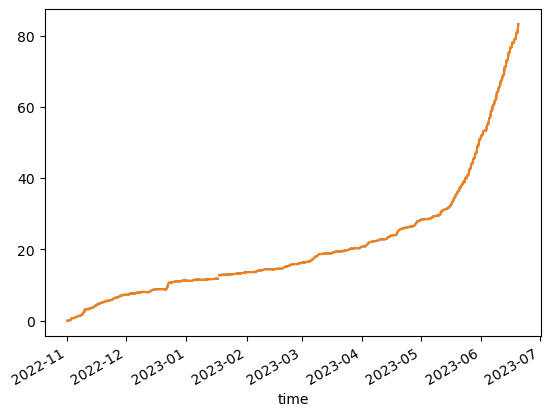

In [22]:
planar_fitted_data_df['w_h2o__10m_c'].cumsum().plot()
planar_fitted_data_df['w_h2o__10m_c_fit'].cumsum().plot()

In [23]:
if PLANAR_FIT:
    planar_fitted_data_df = planar_fitted_data_df[[c for c in planar_fitted_data_df.columns if c.endswith('_fit')]]
    planar_fitted_data_df.columns = [c.replace('_fit', '') for c in planar_fitted_data_df.columns]
    planar_fitted_data_df = planar_fitted_data_df.loc[ start_date : end_date ]
    planar_fitted_data_df.index = planar_fitted_data_df.index - dt.timedelta(minutes=15)
    planar_fitted_ds = planar_fitted_data_df.to_xarray()
    sos_ds = sos_ds.assign(planar_fitted_ds)

In [24]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c',   'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue',  'w_10m_ue',
    'w_1m_uw',  'w_3m_uw',  'w_10m_uw',
    'w_1m_d',   'w_3m_d',   'w_10m_d',
]]
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)').scale(domain = [-0.02,0.02]),
    alt.Color('tower:N'),
    alt.Facet('height:O', columns=4),
    tooltip='variable',
).properties(width = 125, height = 125, title='Streamwise').display(renderer='svg')

alt.Chart(...)

In [25]:
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)').scale(domain = [-0.02,0.02]),
    alt.Facet('tower:N', columns=4),
    alt.Color('height:O').scale(scheme='turbo'),
    tooltip='variable',
).properties(width = 125, height = 125, title='Streamwise').display(renderer='svg')

alt.Chart(...)

# Convert to local time and isolate to study period

In [26]:
sos_ds = utils.modify_xarray_timezone(sos_ds, 'UTC', 'US/Mountain')

In [27]:
sos_ds = sos_ds.reset_coords(
    'time (UTC)', drop=True
).reset_coords(
    'time (US/Mountain)', drop=True
) 

In [28]:
sos_ds = sos_ds.to_dataframe().sort_index().loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE].to_xarray()

# Copy fluxes into variables named "raw" so that we keep the raw fluxes around

In [29]:
important_ec_variables = [
    'w_h2o__3m_ue', 'w_h2o__10m_ue', 
    'w_h2o__3m_d', 'w_h2o__10m_d',
    'w_h2o__3m_uw', 'w_h2o__10m_uw', 
    'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c'
    ]

In [30]:
for var in important_ec_variables:
    sos_ds[
        var + '_raw'
    ] = sos_ds[var]

# QC1: Instrument flags

## Examine what caused instrument flags

### Timestamps during issue-causing conditions

In [31]:
snowfall_mask_df = pd.read_csv(snowfall_mask_file, index_col=0)
snowfall_mask_df.index.name = 'time'
snowfall_mask_df.index = pd.to_datetime(snowfall_mask_df.index)
snowfall_mask_df
snowfall_mask_df = utils.modify_df_timezone(snowfall_mask_df.reset_index(), 'UTC', "US/Mountain").set_index('time')
times_with_snowfall = snowfall_mask_df[~snowfall_mask_df.SAIL_gts_pluvio].index
times_with_snowfall = set(times_with_snowfall)

In [32]:
times_with_bs = sos_ds[['SF_avg_1m_ue', 'SF_avg_2m_ue']].to_dataframe()
times_with_bs['is_bs'] = (times_with_bs['SF_avg_1m_ue'] > 0) | (times_with_bs['SF_avg_2m_ue'] > 0)
times_with_bs = times_with_bs[times_with_bs.is_bs].index
times_with_bs = set(times_with_bs)

In [33]:
times_with_rh_above_78 = sos_ds[['RH_3m_c']].to_dataframe()
times_with_rh_above_78 = times_with_rh_above_78[times_with_rh_above_78['RH_3m_c'] > 78].index
times_with_rh_above_78 = set(times_with_rh_above_78)

In [34]:
times_daytime_after_april1 = sos_ds.time.to_series()
times_daytime_after_april1 = times_daytime_after_april1[(times_daytime_after_april1.dt.hour > 9) & (times_daytime_after_april1.dt.hour < 17)]
times_daytime_after_april1 = times_daytime_after_april1[times_daytime_after_april1 > '20230301']
times_daytime_after_april1 = set(times_daytime_after_april1)

In [35]:
len(times_with_snowfall), len(times_with_bs), len(times_with_rh_above_78), len(times_daytime_after_april1), 

(933, 1845, 3378, 1554)

### Irga flags

In [36]:
important_ec_variables_suffixes = [c[7:] for c in important_ec_variables]
important_irgadiag_variables = ['irgadiag_' + c[7:] for c in important_ec_variables]

irgadiag_filtering_df   = sos_ds[important_irgadiag_variables].to_dataframe()
lhfluxes_df             = sos_ds[important_ec_variables].to_dataframe()
irgadiag_filtering_df   = irgadiag_filtering_df.sort_index().loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]
lhfluxes_df             = lhfluxes_df.sort_index().loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]

# irgadiag > 9000 AND lhflux is not nan
lhfluxes_df.columns = [c[7:] for c in lhfluxes_df.columns]
irgadiag_filtering_df.columns = [c[9:] for c in irgadiag_filtering_df.columns]
removed_by_irgadiag_df = ((~np.isnan(lhfluxes_df)) & (irgadiag_filtering_df > PERCENTAGE_DIAG))

In [37]:
removed_by_irgadiag_df.sum().sum()

1662

In [38]:
removed_by_irgadiag_df[removed_by_irgadiag_df.index.isin(
    times_with_snowfall
)].sum().sum() / removed_by_irgadiag_df.sum().sum()

0.2858002406738869

In [39]:
removed_by_irgadiag_df[removed_by_irgadiag_df.index.isin(
    times_with_bs
)].sum().sum() / removed_by_irgadiag_df.sum().sum()

0.19554753309265946

In [40]:
removed_by_irgadiag_df[removed_by_irgadiag_df.index.isin(
    times_with_snowfall.union(times_with_bs)
)].sum().sum() / removed_by_irgadiag_df.sum().sum()

0.3941034897713598

In [41]:
removed_by_irgadiag_df[removed_by_irgadiag_df.index.isin(
    times_with_rh_above_78
)].sum().sum() / removed_by_irgadiag_df.sum().sum()

0.6582430806257521

In [42]:
removed_by_irgadiag_df[removed_by_irgadiag_df.index.isin(
    times_daytime_after_april1
)].sum().sum() / removed_by_irgadiag_df.sum().sum()

0.34777376654632974

In [43]:
removed_by_irgadiag_df[removed_by_irgadiag_df.index.isin(
    times_daytime_after_april1
)].sum() / removed_by_irgadiag_df.sum()

3m_ue     0.232323
10m_ue    0.055556
3m_d      0.275229
10m_d     0.222222
3m_uw     0.085106
10m_uw    0.218182
2m_c      0.062500
3m_c      0.081395
5m_c      0.028571
10m_c     0.098765
15m_c     0.654867
20m_c     0.436047
dtype: float64

In [44]:
removed_by_irgadiag_df[removed_by_irgadiag_df.index.isin(
    times_with_rh_above_78.union(times_daytime_after_april1)
)].sum().sum() / removed_by_irgadiag_df.sum().sum()

0.907942238267148

In [45]:
removed_by_irgadiag_df[removed_by_irgadiag_df.index.isin(
    times_with_snowfall.union(times_with_bs).union(times_with_rh_above_78).union(times_daytime_after_april1)    
)].sum().sum() / removed_by_irgadiag_df.sum().sum()

0.9139590854392299

### Sonic flags

In [46]:
important_ec_variables_suffixes = [c[7:] for c in important_ec_variables]
important_ldiag_variables = ['ldiag_' + c[7:] for c in important_ec_variables]

ldiag_filtering_df   = sos_ds[important_ldiag_variables].to_dataframe()
lhfluxes_df             = sos_ds[important_ec_variables].to_dataframe()
ldiag_filtering_df   = ldiag_filtering_df.sort_index().loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]
lhfluxes_df             = lhfluxes_df.sort_index().loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]

# ldiag > 9000 AND lhflux is not nan
lhfluxes_df.columns = [c[7:] for c in lhfluxes_df.columns]
ldiag_filtering_df.columns = [c[6:] for c in ldiag_filtering_df.columns]
removed_by_ldiag_df = ((~np.isnan(lhfluxes_df)) & (ldiag_filtering_df > PERCENTAGE_DIAG))

In [47]:
removed_by_ldiag_df.sum()

3m_ue     99
10m_ue    28
3m_d      46
10m_d     34
3m_uw     52
10m_uw    22
2m_c      33
3m_c      76
5m_c      67
10m_c     21
15m_c     24
20m_c     36
dtype: int64

In [48]:
removed_by_ldiag_df.loc['20221221': '20221222'].sum().sum() / removed_by_ldiag_df.sum().sum()

0.22676579925650558

In [49]:
removed_by_ldiag_df[removed_by_ldiag_df.index.isin(
    times_with_snowfall
)].sum().sum() / removed_by_ldiag_df.sum().sum()

0.4144981412639405

In [50]:
removed_by_ldiag_df[removed_by_ldiag_df.index.isin(
    times_with_bs
)].sum().sum() / removed_by_ldiag_df.sum().sum()

0.4423791821561338

In [51]:
removed_by_ldiag_df[removed_by_ldiag_df.index.isin(
    times_with_snowfall.union(times_with_bs)
)].sum().sum() / removed_by_ldiag_df.sum().sum()

0.7193308550185874

In [52]:
removed_by_ldiag_df[removed_by_ldiag_df.index.isin(
    times_with_rh_above_78
)].sum().sum() / removed_by_ldiag_df.sum().sum()

0.7565055762081785

In [53]:
removed_by_ldiag_df[removed_by_ldiag_df.index.isin(
    times_daytime_after_april1
)].sum().sum() / removed_by_ldiag_df.sum().sum()

0.3215613382899628

In [54]:
removed_by_ldiag_df[removed_by_ldiag_df.index.isin(
    times_with_snowfall.union(times_with_bs).union(times_with_rh_above_78).union(times_daytime_after_april1)    
)].sum()

3m_ue     97
10m_ue    28
3m_d      44
10m_d     34
3m_uw     51
10m_uw    22
2m_c      33
3m_c      75
5m_c      66
10m_c     21
15m_c     24
20m_c     36
dtype: int64

In [55]:
removed_by_ldiag_df[removed_by_ldiag_df.index.isin(
    times_with_snowfall.union(times_with_bs).union(times_with_rh_above_78).union(times_daytime_after_april1)    
)].sum().sum() / removed_by_ldiag_df.sum().sum()

0.9869888475836431

## Set bad Irga measurements to NaN

The NCAR report recommends all Irga-related measurements be set to NaN when irgadiag is non-zero.  They did this for some but not all of the data.

In [56]:
print('h2o_flux_var', 'irgadiag_var', 'old_nan_count_badirga', 'new_nan_count_badirga', 'old_mean', 'new_mean')
var_ls = []
old_nan_count_badirga_ls = []
new_nan_count_badirga_ls = []
old_mean_ls = []
new_mean_ls = []
old_median_ls = []
new_median_ls = []
for suffix in ec_measurement_suffixes:
    h2o_flux_var = 'w_h2o__' + suffix
    irgadiag_var = 'irgadiag_' + suffix

    if irgadiag_var in sos_ds.variables and h2o_flux_var in sos_ds.variables:
        old_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        old_mean = sos_ds[h2o_flux_var].mean().item()
        old_median = sos_ds[h2o_flux_var].median().item()

        sos_ds[h2o_flux_var] = sos_ds[h2o_flux_var].where(sos_ds[irgadiag_var] <= PERCENTAGE_DIAG)
    
        new_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        new_mean = sos_ds[h2o_flux_var].mean().item()
        new_median = sos_ds[h2o_flux_var].median().item()
        print(h2o_flux_var, irgadiag_var, old_nan_count_badirga, new_nan_count_badirga, round(old_mean,6), round(new_mean,6))
        var_ls.append(h2o_flux_var)
        old_nan_count_badirga_ls.append(old_nan_count_badirga)
        new_nan_count_badirga_ls.append(new_nan_count_badirga)
        old_mean_ls.append(old_mean)
        new_mean_ls.append(new_mean)
        old_median_ls.append(old_median)
        new_median_ls.append(new_median)
    else:
        print(f"Variable {h2o_flux_var} or {irgadiag_var} not in dataset.")
        var_ls.append(h2o_flux_var)
        old_nan_count_badirga_ls.append(np.nan)
        new_nan_count_badirga_ls.append(np.nan)
        old_mean_ls.append(np.nan)
        new_mean_ls.append(np.nan)
        old_median_ls.append(np.nan)
        new_median_ls.append(np.nan)

h2o_flux_var irgadiag_var old_nan_count_badirga new_nan_count_badirga old_mean new_mean
w_h2o__1m_ue irgadiag_1m_ue 7001 7049 0.010312 0.01043
Variable w_h2o__2m_ue or irgadiag_2m_ue not in dataset.
w_h2o__3m_ue irgadiag_3m_ue 944 1043 0.007079 0.007149
w_h2o__10m_ue irgadiag_10m_ue 810 900 0.006896 0.006956
w_h2o__1m_d irgadiag_1m_d 6685 6725 0.009265 0.009241
Variable w_h2o__2m_d or irgadiag_2m_d not in dataset.
w_h2o__3m_d irgadiag_3m_d 1005 1114 0.007082 0.007239
w_h2o__10m_d irgadiag_10m_d 899 989 0.007112 0.007188
w_h2o__1m_uw irgadiag_1m_uw 7713 7733 0.01201 0.012053
Variable w_h2o__2m_uw or irgadiag_2m_uw not in dataset.
Variable w_h2o__2_5m_uw or irgadiag_2_5m_uw not in dataset.
w_h2o__3m_uw irgadiag_3m_uw 932 1026 0.007255 0.00731
w_h2o__10m_uw irgadiag_10m_uw 1138 1248 0.007127 0.007144
w_h2o__1m_c irgadiag_1m_c 4784 4853 0.007795 0.007901
w_h2o__2m_c irgadiag_2m_c 684 780 0.006749 0.006825
w_h2o__3m_c irgadiag_3m_c 678 764 0.00704 0.007052
w_h2o__5m_c irgadiag_5m_c 1051 112

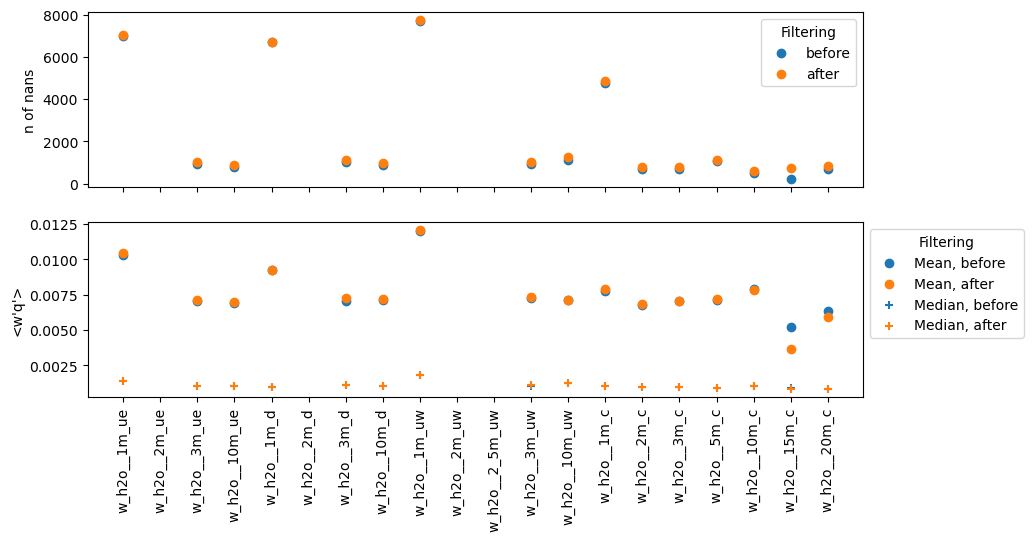

In [57]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_badirga_ls, label = 'before', color='tab:blue')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_badirga_ls, label = 'after', color='tab:orange')

axes[1].scatter(var_ls, old_mean_ls, label = 'Mean, before', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'Mean, after', color='tab:orange')

axes[1].scatter(var_ls, old_median_ls, label = 'Median, before', marker='+', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_median_ls, label = 'Median, after', marker='+', color='tab:orange')

for ax in axes:
    ax.tick_params(rotation=90, axis='x')
    ax.legend(title='Filtering', bbox_to_anchor=(1,1))

## Set bad Sonic measurements to Nan

In [58]:
print('h2o_flux_var', 'ldiag_var', 'old_nan_count_badsonic', 'new_nan_count_badsonic', 'old_mean', 'new_mean')

var_ls = []
old_nan_count_badsonic_ls = []
new_nan_count_badsonic_ls = []
old_mean_ls = []
new_mean_ls = []
for suffix in ec_measurement_suffixes:
    w_var = 'w_' + suffix
    h2o_flux_var = 'w_h2o__' + suffix
    sonicdiag_var = 'ldiag_' + suffix

    if h2o_flux_var in sos_ds.variables and sonicdiag_var in sos_ds.variables:
        old_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        old_mean = sos_ds[h2o_flux_var].mean().item()
        
        sos_ds[h2o_flux_var] = sos_ds[h2o_flux_var].where(sos_ds[sonicdiag_var] <= PERCENTAGE_DIAG)

        new_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        new_mean = sos_ds[h2o_flux_var].mean().item()
        print(h2o_flux_var, sonicdiag_var, old_nan_count_badsonic, new_nan_count_badsonic, round(old_mean,6), round(new_mean,6))
        var_ls.append(h2o_flux_var)
        old_nan_count_badsonic_ls.append(old_nan_count_badsonic)
        new_nan_count_badsonic_ls.append(new_nan_count_badsonic)
        old_mean_ls.append(old_mean)
        new_mean_ls.append(new_mean)
    else:
        print(f"Variable {h2o_flux_var} or {sonicdiag_var} not in dataset.")
        var_ls.append(h2o_flux_var)
        old_nan_count_badsonic_ls.append(np.nan)
        new_nan_count_badsonic_ls.append(np.nan)
        old_mean_ls.append(np.nan)
        new_mean_ls.append(np.nan)

h2o_flux_var ldiag_var old_nan_count_badsonic new_nan_count_badsonic old_mean new_mean
w_h2o__1m_ue ldiag_1m_ue 7049 7074 0.01043 0.010422
Variable w_h2o__2m_ue or ldiag_2m_ue not in dataset.
w_h2o__3m_ue ldiag_3m_ue 1043 1126 0.007149 0.00711
w_h2o__10m_ue ldiag_10m_ue 900 925 0.006956 0.006912
w_h2o__1m_d ldiag_1m_d 6725 6859 0.009241 0.009376
Variable w_h2o__2m_d or ldiag_2m_d not in dataset.
w_h2o__3m_d ldiag_3m_d 1114 1154 0.007239 0.00725
w_h2o__10m_d ldiag_10m_d 989 1017 0.007188 0.007059
w_h2o__1m_uw ldiag_1m_uw 7733 7800 0.012053 0.012212
Variable w_h2o__2m_uw or ldiag_2m_uw not in dataset.
Variable w_h2o__2_5m_uw or ldiag_2_5m_uw not in dataset.
w_h2o__3m_uw ldiag_3m_uw 1026 1074 0.00731 0.007255
w_h2o__10m_uw ldiag_10m_uw 1248 1261 0.007144 0.007038
w_h2o__1m_c ldiag_1m_c 4853 4884 0.007901 0.007931
w_h2o__2m_c ldiag_2m_c 780 809 0.006825 0.006771
w_h2o__3m_c ldiag_3m_c 764 833 0.007052 0.007017
w_h2o__5m_c ldiag_5m_c 1121 1187 0.007162 0.00713
w_h2o__10m_c ldiag_10m_c 593 6

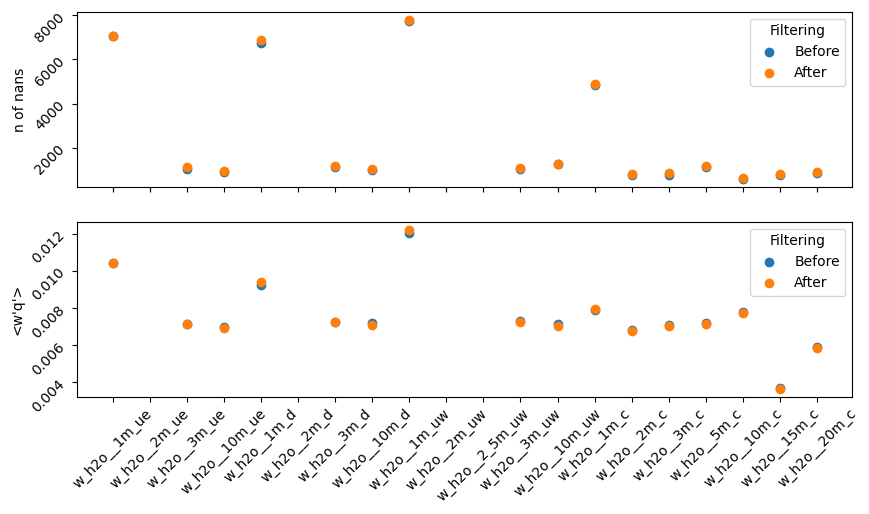

In [59]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_badsonic_ls, label = 'Before')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_badsonic_ls, label = 'After')

axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'After')

for ax in axes:
    ax.tick_params(rotation=45)
    ax.legend(title='Filtering')

# QC2: Plausibility limits

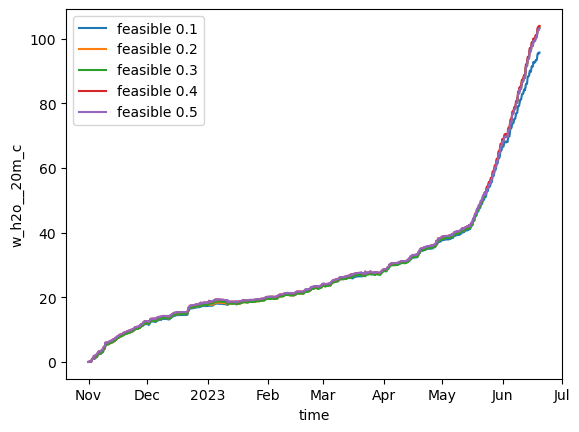

In [60]:
(sos_ds['w_h2o__20m_c'].where(
    np.abs(sos_ds['w_h2o__20m_c']) < 0.1
)*1.8).sel(time = slice(STUDY_PERIOD_START_DATE, STUDY_PERIOD_END_DATE)).cumsum().plot(label='feasible 0.1')
(sos_ds['w_h2o__20m_c'].where(
    np.abs(sos_ds['w_h2o__20m_c']) < 0.2
)*1.8).sel(time = slice(STUDY_PERIOD_START_DATE, STUDY_PERIOD_END_DATE)).cumsum().plot(label='feasible 0.2')
(sos_ds['w_h2o__20m_c'].where(
    np.abs(sos_ds['w_h2o__20m_c']) < 0.3
)*1.8).sel(time = slice(STUDY_PERIOD_START_DATE, STUDY_PERIOD_END_DATE)).cumsum().plot(label='feasible 0.3')
(sos_ds['w_h2o__20m_c'].where(
    np.abs(sos_ds['w_h2o__20m_c']) < 0.4
)*1.8).sel(time = slice(STUDY_PERIOD_START_DATE, STUDY_PERIOD_END_DATE)).cumsum().plot(label='feasible 0.4')
(sos_ds['w_h2o__20m_c'].where(
    np.abs(sos_ds['w_h2o__20m_c']) < 0.5
)*1.8).sel(time = slice(STUDY_PERIOD_START_DATE, STUDY_PERIOD_END_DATE)).cumsum().plot(label='feasible 0.5')
plt.legend()

In [61]:
latent_heat_of_vaporization = 2838 * units("J/g")
PLAUSIBILITY_LIMIT = 0.2

(PLAUSIBILITY_LIMIT  * units("g/(m^2 * s)") * latent_heat_of_vaporization).to("W/m^2")

<Quantity(567.6, 'watt / meter ** 2')>

In [62]:
print('h2o_flux_var', 'ldiag_var', 'old_nan_count_badsonic', 'new_nan_count_badsonic', 'old_mean', 'new_mean')

var_ls = []
old_nan_count_plausibilitylimit_ls = []
new_nan_count_plausibilitylimit_ls = []
old_mean_ls = []
new_mean_ls = []
for suffix in ec_measurement_suffixes:
    w_var = 'w_' + suffix
    h2o_flux_var = 'w_h2o__' + suffix
    sonicdiag_var = 'ldiag_' + suffix

    if h2o_flux_var in sos_ds.variables and sonicdiag_var in sos_ds.variables:
        old_nan_count_plausibilitylimit = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        old_mean = sos_ds[h2o_flux_var].mean().item()
        
        sos_ds[h2o_flux_var] = sos_ds[h2o_flux_var].where(np.abs(sos_ds[h2o_flux_var]) < PLAUSIBILITY_LIMIT)
    
        new_nan_count_plausibilitylimit = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        new_mean = sos_ds[h2o_flux_var].mean().item()
        print(h2o_flux_var, sonicdiag_var, old_nan_count_plausibilitylimit, new_nan_count_plausibilitylimit, round(old_mean,6), round(new_mean,6))
        var_ls.append(h2o_flux_var)
        old_nan_count_plausibilitylimit_ls.append(old_nan_count_plausibilitylimit)
        new_nan_count_plausibilitylimit_ls.append(new_nan_count_plausibilitylimit)
        old_mean_ls.append(old_mean)
        new_mean_ls.append(new_mean)
    else:
        print(f"Variable {h2o_flux_var} or {sonicdiag_var} not in dataset.")
        var_ls.append(h2o_flux_var)
        old_nan_count_plausibilitylimit_ls.append(np.nan)
        new_nan_count_plausibilitylimit_ls.append(np.nan)
        old_mean_ls.append(np.nan)
        new_mean_ls.append(np.nan)

h2o_flux_var ldiag_var old_nan_count_badsonic new_nan_count_badsonic old_mean new_mean
w_h2o__1m_ue ldiag_1m_ue 7074 7074 0.010422 0.010422
Variable w_h2o__2m_ue or ldiag_2m_ue not in dataset.
w_h2o__3m_ue ldiag_3m_ue 1126 1127 0.00711 0.007133
w_h2o__10m_ue ldiag_10m_ue 925 929 0.006912 0.006884
w_h2o__1m_d ldiag_1m_d 6859 6859 0.009376 0.009376
Variable w_h2o__2m_d or ldiag_2m_d not in dataset.
w_h2o__3m_d ldiag_3m_d 1154 1155 0.00725 0.007295
w_h2o__10m_d ldiag_10m_d 1017 1018 0.007059 0.007103
w_h2o__1m_uw ldiag_1m_uw 7800 7800 0.012212 0.012212
Variable w_h2o__2m_uw or ldiag_2m_uw not in dataset.
Variable w_h2o__2_5m_uw or ldiag_2_5m_uw not in dataset.
w_h2o__3m_uw ldiag_3m_uw 1074 1074 0.007255 0.007255
w_h2o__10m_uw ldiag_10m_uw 1261 1267 0.007038 0.007129
w_h2o__1m_c ldiag_1m_c 4884 4884 0.007931 0.007931
w_h2o__2m_c ldiag_2m_c 809 809 0.006771 0.006771
w_h2o__3m_c ldiag_3m_c 833 833 0.007017 0.007017
w_h2o__5m_c ldiag_5m_c 1187 1187 0.00713 0.00713
w_h2o__10m_c ldiag_10m_c 612

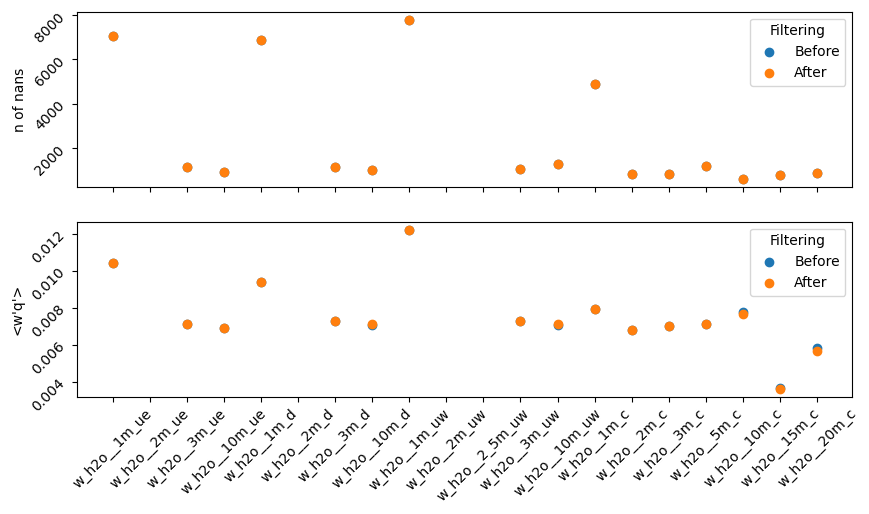

In [63]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_plausibilitylimit_ls, label = 'Before')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_plausibilitylimit_ls, label = 'After')

axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'After')

for ax in axes:
    ax.tick_params(rotation=45)
    ax.legend(title='Filtering')

# Analyze cleaning steps

In [64]:
nan_counts_df = pd.DataFrame({
    'variable':                         var_ls,
    'n':                                len(sos_ds.time),
    'original nan count':               old_nan_count_badirga_ls, 
    'nans after bad irga removed':      new_nan_count_badirga_ls, 
    'nans after bad sonic removed':     new_nan_count_badsonic_ls, 
    'nans after plausibility limit':    new_nan_count_plausibilitylimit_ls
})
limited_nan_counts_df = nan_counts_df[ 
    (~nan_counts_df.variable.str.contains('__1m_'))
    
    &
    (~nan_counts_df.variable.str.contains('__2_5m_'))
]
limited_nan_counts_df.dropna()

,variable,n,original nan count,nans after bad irga removed,nans after bad sonic removed,nans after plausibility limit
2,w_h2o__3m_ue,11076,944.0,1043.0,1126.0,1127.0
3,w_h2o__10m_ue,11076,810.0,900.0,925.0,929.0
6,w_h2o__3m_d,11076,1005.0,1114.0,1154.0,1155.0
7,w_h2o__10m_d,11076,899.0,989.0,1017.0,1018.0
11,w_h2o__3m_uw,11076,932.0,1026.0,1074.0,1074.0
12,w_h2o__10m_uw,11076,1138.0,1248.0,1261.0,1267.0
14,w_h2o__2m_c,11076,684.0,780.0,809.0,809.0
15,w_h2o__3m_c,11076,678.0,764.0,833.0,833.0
16,w_h2o__5m_c,11076,1051.0,1121.0,1187.0,1187.0
17,w_h2o__10m_c,11076,512.0,593.0,612.0,615.0


In [65]:
limited_nan_counts_df['Valid measurements'] = limited_nan_counts_df['n'] - limited_nan_counts_df['original nan count']
limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original nan count']
limited_nan_counts_df['Data removed by CSAT3 flag'] = limited_nan_counts_df['nans after bad sonic removed'] - limited_nan_counts_df['nans after bad irga removed']
limited_nan_counts_df['Data removed by plausibility limit'] = limited_nan_counts_df['nans after plausibility limit'] - limited_nan_counts_df['nans after bad sonic removed']
limited_nan_counts_df[[
    'variable',
    'n',
    'Valid measurements',
    'Data removed by EC150 flag',
    'Data removed by CSAT3 flag',
    'Data removed by plausibility limit'
]].dropna()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_3825/840410405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_nan_counts_df['Valid measurements'] = limited_nan_counts_df['n'] - limited_nan_counts_df['original nan count']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_3825/840410405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original 

,variable,n,Valid measurements,Data removed by EC150 flag,Data removed by CSAT3 flag,Data removed by plausibility limit
2,w_h2o__3m_ue,11076,10132.0,99.0,83.0,1.0
3,w_h2o__10m_ue,11076,10266.0,90.0,25.0,4.0
6,w_h2o__3m_d,11076,10071.0,109.0,40.0,1.0
7,w_h2o__10m_d,11076,10177.0,90.0,28.0,1.0
11,w_h2o__3m_uw,11076,10144.0,94.0,48.0,0.0
12,w_h2o__10m_uw,11076,9938.0,110.0,13.0,6.0
14,w_h2o__2m_c,11076,10392.0,96.0,29.0,0.0
15,w_h2o__3m_c,11076,10398.0,86.0,69.0,0.0
16,w_h2o__5m_c,11076,10025.0,70.0,66.0,0.0
17,w_h2o__10m_c,11076,10564.0,81.0,19.0,3.0


In [66]:
src = sos_ds[['SF_avg_1m_ue', 'SF_avg_2m_ue', 'ldiag_3m_c']].to_dataframe().reset_index()
src['SF_avg_ue'] = src['SF_avg_1m_ue'] + src['SF_avg_2m_ue']
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
src['on Dec 21/22'] = (src.time.dt.date == dt.date(2022,12,22)) | (src.time.dt.date == dt.date(2022,12,21))
src = src.query("SF_avg_ue > 0")
rule = alt.Chart().transform_calculate(rule = '0.1').mark_rule(strokeDash=[2,2]).encode(y='rule:Q')
bad_sonic_data = (
    rule + alt.Chart(src).mark_circle(size=10).encode(
        alt.X("SF_avg_ue").title("Blowing snow flux (g/m^2/s)").scale(type='log'),
        alt.Y("ldiag_3m_c").title(["Fraction of 20hz sonic anemometer", "measurements flagged (Tower C, 3m)"]),
        alt.Color("on Dec 21/22:N")
    ).properties(width=200, height=200)
).configure_axis(grid=False).configure_legend(columns=2, orient='top')
bad_sonic_data.save("bad_sonic_data.png", ppi=200)
display(bad_sonic_data)

alt.LayerChart(...)

In [67]:
src = sos_ds[['RH_3m_c', 'SF_avg_1m_ue', 'SF_avg_2m_ue', 'ldiag_3m_c', 'ldiag_5m_c', 'ldiag_10m_c', 'ldiag_15m_c', 'ldiag_20m_c']].to_dataframe().reset_index()
src['SF_avg_ue'] = src['SF_avg_1m_ue'] + src['SF_avg_2m_ue']
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
src['on Dec 21/22'] = (src.time.dt.date == dt.date(2022,12,22)) | (src.time.dt.date == dt.date(2022,12,21))
src = src.query("SF_avg_ue == 0")
rule = alt.Chart().transform_calculate(rule = '9000').mark_rule(strokeDash=[2,2]).encode(y='rule:Q')
bad_sonic_data = (
    alt.Chart(src).transform_fold([
        'ldiag_3m_c', 'ldiag_5m_c', 'ldiag_10m_c', 'ldiag_15m_c', 'ldiag_20m_c'
    ]).mark_circle(size=10).encode(
        alt.X("RH_3m_c").title("RH (%)"),
        alt.Y("value:Q").title(["Fraction of 20hz sonic anemometer", "measurements flagged (Tower C, 3m)"]),
        alt.Color("on Dec 21/22:N"),
        alt.Column('key:N').sort(['ldiag_3m_c', 'ldiag_5m_c', 'ldiag_10m_c', 'ldiag_15m_c', 'ldiag_20m_c'])
    ).properties(width=200, height=200)
).configure_axis(grid=False).configure_legend(columns=2, orient='top')
bad_sonic_data.save("bad_sonic_data.png", ppi=200)
display(bad_sonic_data)

alt.Chart(...)

In [68]:
display(src.query("ldiag_3m_c > 0.1")['on Dec 21/22'].value_counts())

on Dec 21/22
False    898
True       2
Name: count, dtype: int64

In [69]:
src = sos_ds[['RH_3m_c', 'RH_5m_c', 'RH_10m_c', 'RH_15m_c', 'RH_20m_c', 
                'irgadiag_3m_c', 'irgadiag_5m_c', 'irgadiag_10m_c', 'irgadiag_15m_c', 'irgadiag_20m_c', 
            ]].to_dataframe().reset_index()
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')

bad_irga_data_3m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_3m_c:Q").title("Relative humidity, 3m (%)"),
        alt.Y("irgadiag_3m_c:Q").title(["Sum of EC150 diagnostic flags", "3m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
bad_irga_data_5m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_5m_c:Q").title("Relative humidity, 5m (%)"),
        alt.Y("irgadiag_5m_c:Q").title(["Sum of EC150 diagnostic flags", "5m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
bad_irga_data_10m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_10m_c:Q").title("Relative humidity, 10m (%)"),
        alt.Y("irgadiag_10m_c:Q").title(["Sum of EC150 diagnostic flags", "10m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
bad_irga_data_15m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_15m_c:Q").title("Relative humidity, 15m (%)"),
        alt.Y("irgadiag_15m_c:Q").title(["Sum of EC150 diagnostic flags", "15m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
bad_irga_data_20m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_20m_c:Q").title("Relative humidity, 20m (%)"),
        alt.Y("irgadiag_20m_c:Q").title(["Sum of EC150 diagnostic flags", "20m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
rule = alt.Chart().transform_calculate(y='9000').mark_rule(color='red', strokeDash=[4,2]).encode(y='y:Q')
bad_irga_data = (
    ((bad_irga_data_3m+rule) | (bad_irga_data_5m+rule) | (bad_irga_data_10m+rule)  )
    & ((bad_irga_data_15m+rule)| (bad_irga_data_20m+rule))
    ).configure_axis(grid=False)
bad_irga_data.save("bad_irga_data.png", ppi=200)
display(bad_irga_data)

alt.VConcatChart(...)

# QC3: Snowfall

In [70]:
# if FILTER_SNOWFALL:
#     # open the snowfall dataset
#     snowfall_mask_df = pd.read_csv(snowfall_mask_file, index_col=0)
#     snowfall_mask_df.index.name = 'time'
#     snowfall_mask_df.index = pd.to_datetime(snowfall_mask_df.index)

#     # add it as a variable too the dataset
#     sos_ds = sos_ds.assign({
#         'snowfall_mask': snowfall_mask_df.to_xarray()['SAIL_gts_pluvio'].reindex_like(sos_ds).astype('bool')
#     })

#     for suffix in ec_measurement_suffixes:
#         w_var = 'w_' + suffix
#         h2o_flux_var = 'w_h2o__' + suffix
#         if h2o_flux_var in sos_ds.variables and sonicdiag_var in sos_ds.variables:
#             prefix = 'w_h2o__'
#             var = prefix + suffix
#             if var in sos_ds:
#                 sos_ds[var] = sos_ds[var].where(sos_ds['snowfall_mask'].values, 0)
#         else:
#             print(f"Variable {h2o_flux_var} or {sonicdiag_var} not in dataset.")

# QC4: Non-stationarity

Following https://link.springer.com/10.1007/978-3-030-52171-4_55, http://link.springer.com/10.1007/s10546-015-0103-zz

See equation 55.16 in https://link.springer.com/10.1007/978-3-030-52171-4_55

In [71]:
sos_ds5min_localized = utils.modify_xarray_timezone(sos_ds5min, 'UTC', 'US/Mountain')
sos_ds5min_localized = sos_ds5min_localized.to_dataframe().sort_index().loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE].to_xarray()
sos_ds5min_localized

<xarray.Dataset> Size: 238MB
Dimensions:             (time: 66456)
Coordinates:
  * time                (time) datetime64[ns] 532kB 2022-11-01T00:02:30 ... 2...
Data variables: (12/800)
    u_10m_c             (time) float32 266kB 1.568 -0.3622 ... 0.03797 2.017
    Vpile_ue            (time) float32 266kB -4.136e-05 -3.997e-05 ... 4.848e-05
    co2_1m_uw           (time) float32 266kB 0.6508 0.652 ... 0.5827 0.5804
    Gsoil_d             (time) float32 266kB -30.01 -30.71 ... 2.105 1.311
    u_h2o__10m_c        (time) float32 266kB 0.007666 0.002715 ... -0.1825
    v_w__1m_ue          (time) float32 266kB 0.007196 0.007449 ... 0.01096
    ...                  ...
    w_h2o__2_5m_uw      (time) float32 266kB nan nan nan nan ... nan nan nan nan
    u_u__2_5m_uw        (time) float32 266kB nan nan nan nan ... nan nan nan nan
    tc_2_5m_uw          (time) float32 266kB nan nan nan nan ... nan nan nan nan
    v_tc__2_5m_uw       (time) float32 266kB nan nan nan nan ... nan nan nan nan
    time (US/Mountain)  (time) datetime64[ns] 532kB 2022-11-01T00:02:30 ... 2...
    time (UTC)          (time) datetime64[ns] 532kB 2022-11-01T06:02:30 ... 2...

In [72]:
for var in limited_nan_counts_df.variable:
    w_h2o__3m_c_stationarity_stat = 100*np.abs(
        (
            sos_ds5min_localized[var].to_dataframe().resample('30Min').mean()
            -
            sos_ds[var].to_dataframe()
        ) / sos_ds[var].to_dataframe()
    )
    print(
        var,
        (w_h2o__3m_c_stationarity_stat > 30).sum().values, 
        (w_h2o__3m_c_stationarity_stat <= 30).sum().values,
        round((((w_h2o__3m_c_stationarity_stat > 30).sum().values) / (
            ((w_h2o__3m_c_stationarity_stat > 30).sum().values + (w_h2o__3m_c_stationarity_stat <= 30).sum().values)
        ))[0], 2)
    )

w_h2o__2m_ue [1593] [3684] 0.3
w_h2o__3m_ue [3792] [6161] 0.38
w_h2o__10m_ue [5936] [4215] 0.58
w_h2o__2m_d [1418] [3608] 0.28
w_h2o__3m_d [3456] [6469] 0.35
w_h2o__10m_d [5720] [4342] 0.57
w_h2o__2m_uw [1326] [2690] 0.33
w_h2o__3m_uw [3809] [6197] 0.38
w_h2o__10m_uw [5509] [4304] 0.56
w_h2o__2m_c [3727] [6544] 0.36
w_h2o__3m_c [4131] [6116] 0.4
w_h2o__5m_c [4756] [5133] 0.48
w_h2o__10m_c [6243] [4222] 0.6
w_h2o__15m_c [6560] [3726] 0.64
w_h2o__20m_c [6671] [3520] 0.65


In [73]:
from io import StringIO
df = pd.read_csv(StringIO(
"""
height tower dropped1 dropped2 percent_nonstationary
2 ue 1399 3208 0.3
3 ue 2709 4071 0.4
10 ue 4330 2506 0.63
2 d 1259 3085 0.29
3 d 2487 4223 0.37
10 d 4125 2630 0.61
2 uw 1124 2236 0.33
3 uw 2861 3983 0.42
10 uw 4070 2689 0.6
2 c 2759 4235 0.39
3 c 3045 3956 0.43
5 c 3810 3480 0.52
10 c 4600 2568 0.64
15 c 4870 2512 0.66
20 c 4818 2106 0.7
"""
), delim_whitespace=True)
df.percent_nonstationary = df.percent_nonstationary*100
alt.Chart(df).mark_point().encode(
    alt.X("percent_nonstationary:Q").title("% Non-stationary"),
    alt.Y("height").title("height (m)"),
    alt.Color("tower:N")
).properties(width = 150, height = 150).display(renderer='svg')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_3825/1766927043.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO(


alt.Chart(...)

# Add additional variables

## Add snow depth

Open snow depth data

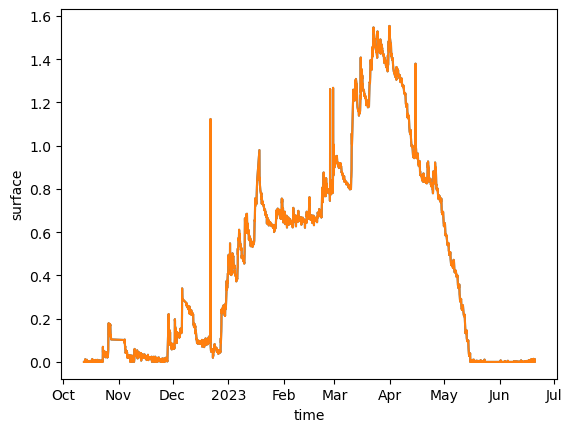

None

In [74]:
towerc_snowdepth_dataset = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/C_l2.nc")
# towerc_lidar_snowdepth_da = towerc_snowdepth_dataset.resample(time='1440Min').median()['surface']
towerc_lidar_snowdepth_da = towerc_snowdepth_dataset.resample(time='30min').median()['surface']
towerc_lidar_snowdepth_da = towerc_lidar_snowdepth_da.interpolate_na(dim = 'time', method='linear')
towerc_lidar_snowdepth_da = towerc_lidar_snowdepth_da.where(towerc_lidar_snowdepth_da > 0, 0)
towerc_lidar_snowdepth_upsample_da = towerc_lidar_snowdepth_da.resample(time = '30Min').pad()
towerc_lidar_snowdepth_da.plot()
towerc_lidar_snowdepth_upsample_da.plot()
display(plt.show())


towerc_snowdepth_df = utils.modify_df_timezone( 
    towerc_lidar_snowdepth_upsample_da.to_dataframe().reset_index(),
    'UTC',
    'US/Mountain'
).set_index('time')
towerc_snowdepth_df = towerc_snowdepth_df.loc[
    sos_ds.time.min().values:sos_ds.time.max().values
]
sos_ds['SnowDepth_c'] = (['time'],  towerc_snowdepth_df.surface.values)

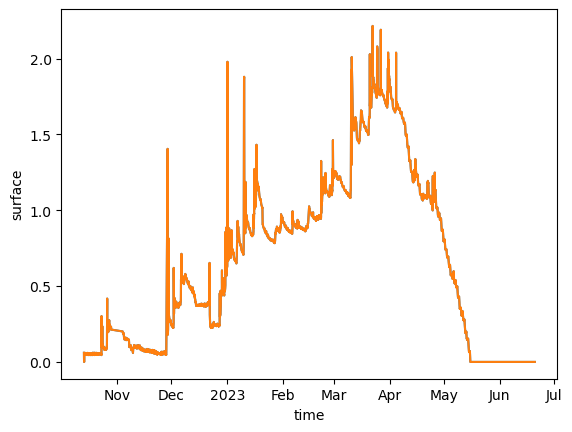

None

In [75]:
towerd_snowdepth_dataset = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/D_from_D_l6.nc")
# towerd_lidar_snowdepth_da = towerd_snowdepth_dataset.resample(time='1440Min').median()['surface']
towerd_lidar_snowdepth_da = towerd_snowdepth_dataset.resample(time='30Min').median()['surface']
towerd_lidar_snowdepth_da = towerd_lidar_snowdepth_da.interpolate_na(dim = 'time', method='linear')
towerd_lidar_snowdepth_da = towerd_lidar_snowdepth_da.where(towerd_lidar_snowdepth_da > 0, 0)
towerd_lidar_snowdepth_upsample_da = towerd_lidar_snowdepth_da.resample(time = '30Min').pad()
towerd_lidar_snowdepth_da.plot()
towerd_lidar_snowdepth_upsample_da.plot()
display(plt.show())


towerd_snowdepth_df = utils.modify_df_timezone( 
    towerd_lidar_snowdepth_upsample_da.to_dataframe().reset_index(),
    'UTC',
    'US/Mountain'
).set_index('time')
towerd_snowdepth_df = towerd_snowdepth_df.loc[
    sos_ds.time.min().values:sos_ds.time.max().values
]
sos_ds['SnowDepth_d'] = (['time'],  towerd_snowdepth_df.surface.values)

## Add/calculate longwave radiation and surface temperatures

In [76]:
sos_ds = variables.add_longwave_radiation(sos_ds)

In [77]:
from sublimpy import variables

In [78]:
sos_ds = sos_ds.drop_duplicates(dim='time')

In [79]:
sos_ds = variables.add_surface_temps(sos_ds)

### Clean $T_s$ variables before proceeding with other calculations

(as of Feb 20, 2023, using NCAR's QC data release, we found a single $T_s$ outlier.)

In [80]:
Tsurf_vars = [v for v in sos_ds.data_vars if v.startswith('Tsurf')]
Tsurf_vars

['Tsurf_c', 'Tsurf_d', 'Tsurf_ue', 'Tsurf_uw']

In [81]:
for var in Tsurf_vars:
    print(f"{var}\t {round(sos_ds[var].min().item(), 1)}\t{round(sos_ds[var].max().item(), 1)}")

Tsurf_c	 -80.8	68.0
Tsurf_d	 -86.2	220.8
Tsurf_ue	 -72.1	101.4
Tsurf_uw	 -33.1	170.7


In [82]:
(
    (sos_ds['Tsurf_c'].values <= -40)
    |
    (sos_ds['Tsurf_c'].values >= 40)
).sum()

7

In [83]:
(
    (sos_ds['Tsurf_c'].values > 0)
).sum()

1116

In [84]:
for var in Tsurf_vars:
    sos_ds[var] = sos_ds[var].where(
        (sos_ds[var].values > -40)
        &
        (sos_ds[var].values < 40)
    ).interpolate_na(
        dim='time', 
        method='linear'
    ).where(
        ~ sos_ds[var].isnull()
    )

In [85]:
for var in Tsurf_vars:
    print(f"{var}\t {round(sos_ds[var].min().item(), 1)}\t{round(sos_ds[var].max().item(), 1)}")

Tsurf_c	 -33.6	36.8
Tsurf_d	 -33.7	32.6
Tsurf_ue	 -33.1	39.8
Tsurf_uw	 -33.1	39.4


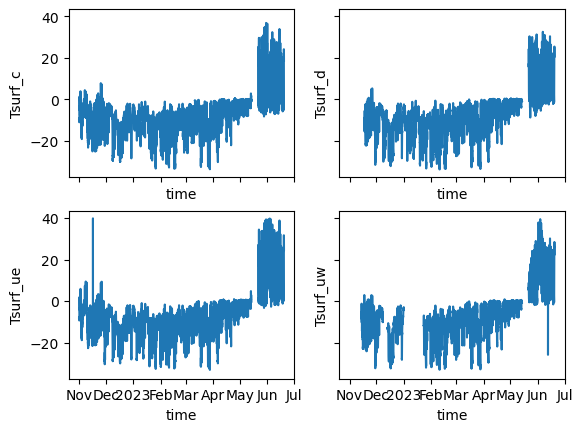

In [86]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True)
sos_ds['Tsurf_c'].plot(ax=axes[0][0])
sos_ds['Tsurf_d'].plot(ax=axes[0][1])
sos_ds['Tsurf_ue'].plot(ax=axes[1][0])
sos_ds['Tsurf_uw'].plot(ax=axes[1][1])

## Add $T_v, \theta, \theta_v, \textbf{tke}, R_i, L$

In [87]:
sos_ds = variables.add_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_surface_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_tke(sos_ds)
sos_ds = variables.add_gradients_and_ri(sos_ds)
sos_ds = variables.add_shear_velocity_and_obukhov_length(sos_ds)

/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/sublimpy/gradients.py:126: OptimizeWarning: Covariance of the parameters could not be estimated
  [a,b,c], _ = curve_fit(LogPolynomial.function, heights, values)
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/sublimpy/gradients.py:126: OptimizeWarning: Covariance of the parameters could not be estimated
  [a,b,c], _ = curve_fit(LogPolynomial.function, heights, values)
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/sublimpy/gradients.py:126: OptimizeWarning: Covariance of the parameters could not be estimated
  [a,b,c], _ = curve_fit(LogPolynomial.function, heights, values)
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/sublimpy/gradients.py:126: OptimizeWarning: Covariance of the parameters could not be estimated
  [a,b,c], _ = curve_fit(LogPolynomial.function, heights, values)
/Users/elischwat/miniforge3/envs

## Add decoupling metric, from Peltola et al. (2021).

We adjust the height value for snow depth.

In [88]:
def decoupling_metric(z, sigma_w, N):
    """Calculate the decoupling metric as described in Peltola et al (2021).

    Peltola, O., Lapo, K., & Thomas, C. K. (2021). A Physics‐Based Universal Indicator for Vertical Decoupling and Mixing Across Canopies Architectures and Dynamic Stabilities. Geophysical Research Letters, 48(5), e2020GL091615. https://doi.org/10.1029/2020GL091615
    
    Args:
        z (float): height of measurements 
        sigma_w (float): standarad deviation of w, vertical velocity
        N (float): Brunt-Vaisala frequency
    """
    # Brunt Vaisala frequency estimated using the bulk theta gradient
    # N = np.sqrt(
    #     g * (theta_e - theta_mean) / theta_mean
    # )

    Lb = sigma_w / N
    omega = Lb / ( np.sqrt(2)*z )
    return omega


In [89]:
#######################################################################
### OLD METHOD USING GRADIENT-BASED N
#######################################################################
from metpy.calc import brunt_vaisala_frequency

sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values
pot_temps = sos_ds[[
    'Tpot_2m_c', 
    'Tpot_3m_c', 
    'Tpot_4m_c', 
    'Tpot_5m_c', 
    'Tpot_6m_c'
]].to_stacked_array(
    'z', ['time']
).values

snow_depth_values = sos_ds['SnowDepth_c']
snow_depth_values_reshaped = np.repeat(sos_ds['SnowDepth_c'].values, 5).reshape(-1, 5)

heights = np.full(pot_temps.shape,  [ 2,    3,    4,    5,    6])
heights_adjusted = heights - snow_depth_values_reshaped
brunt_vaisala_values = [ Ns[1] for Ns in 
    brunt_vaisala_frequency( 
        heights_adjusted * units("meters"),
        pot_temps * units("celsius"), 
        vertical_dim=1
    ).magnitude   
]
z = np.full(sigma_w.shape, 3) - snow_depth_values.values

# decoupling_metric(z, sigma_w, N)
print(len(z))
print(len(sigma_w))
print(len(brunt_vaisala_values))

omegas = decoupling_metric(z, sigma_w, brunt_vaisala_values)
sos_ds['omega_3m_c'] = (['time'],  omegas)
print(len(omegas))



#######################################################################
### NEW METHOD USING BULK N
#######################################################################
# sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values

# snow_depth_values = sos_ds['SnowDepth_c'].values

# air_temp_height = 3
# heights_adjusted = air_temp_height - snow_depth_values
# surf_pottemp = sos_ds['Tsurfpot_c'].values
# air_pottemp = sos_ds['Tpot_3m_c'].values
# surfacealyer_avg_pottemp = 0.5*(air_pottemp + surf_pottemp)
# bulk_brunt_vaisala_value = np.sqrt(
#     metpy.constants.earth_gravity.magnitude.item()*(air_pottemp - surfacealyer_avg_pottemp) 
#     /
#     (surfacealyer_avg_pottemp * heights_adjusted)
# )
# z = np.full(sigma_w.shape, 3) - snow_depth_values

# # decoupling_metric(z, sigma_w, N)
# print(len(z))
# print(len(sigma_w))
# print(len(bulk_brunt_vaisala_value))

# omegas = decoupling_metric(z, sigma_w, bulk_brunt_vaisala_value)
# sos_ds['omega_3m_c'] = (['time'],  omegas)

11074
11074
11074
11074


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_3825/56407381.py:16: RuntimeWarning: divide by zero encountered in divide
  Lb = sigma_w / N


(0.0, 1.0)

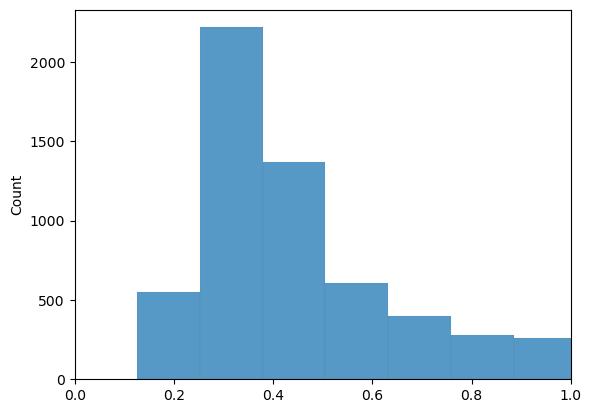

In [90]:
import seaborn as sns
sns.histplot(sos_ds['omega_3m_c'])
plt.xlim(0,1)

## Net LW and Net SW

In [91]:
sos_ds['Rlw_net_9m_d'] = sos_ds['Rlw_in_9m_d'] - sos_ds['Rlw_out_9m_d']
sos_ds['Rsw_net_9m_d'] = sos_ds['Rsw_in_9m_d'] - sos_ds['Rsw_out_9m_d']

sos_ds['Rlw_net_9m_uw'] = sos_ds['Rlw_in_9m_uw'] - sos_ds['Rlw_out_9m_uw']

## Net Radiation

In [92]:
sos_ds['Rnet_9m_d'] = (
    (sos_ds['Rsw_in_9m_d'] + sos_ds['Rlw_in_9m_d'])
    -
    (sos_ds['Rsw_out_9m_d'] + sos_ds['Rlw_out_9m_d'])
)

## Specific humidity

In [93]:
for var in [
    'Tsurfmixingratio_c',
    'mixingratio_1m_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c',
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]:
    new_var_name = var.replace('mixingratio', 'specifichumidity')
    result = specific_humidity_from_mixing_ratio(
        sos_ds[var]*units('g/g')
    )
    sos_ds[new_var_name] = (['time'], result.values)
    sos_ds[new_var_name] = sos_ds[new_var_name].assign_attrs(units=str(result.pint.units))

# Apply sensible and latent heat flux corrections (lots of citations, see here: https://www.eol.ucar.edu/content/corrections-sensible-and-latent-heat-flux-measurements)

In [94]:
rho_d = 1293*units('g/m^3') # density of dry air
rho_a = 1287*units('g/m^3') #density of moist air
mu = 1/0.622
rho_w = metpy.constants.density_water

def corrected_sensible_heat_flux(
    w_tc_,  #sonic_temperature_flux
    w_h2o_, #h2o_flux
    Q,      #specific_humidity
    T,      #absolute_temperature
    A,      #A
    Mr,     #mean_mixing_ratio
):
    Ctc = 0.51*(1 + Q*(mu-1))
    part1 = w_tc_ - Ctc*(T/rho_a)*A*w_h2o_
    part2 = 1 + Ctc*Q
    return part1 / part2

def wpl_corrected_latent_heat_flux(
    w_tc_,  #sonic_temperature_flux
    w_h2o_, #h2o_flux
    Q,      #specific_humidity
    T,      #absolute_temperature
    A,      #A
    Mr,     #mean_mixing_ratio,
    rho_v,
    rho_d     #dry air density
):
    return (
        1 + mu*Mr
    )*(
        w_h2o_ + (rho_v/T)*w_tc_
    ) / rho_d

In [95]:
w_tc__3m_c_corrected = corrected_sensible_heat_flux(
    sos_ds['w_tc__3m_c']*units("(m/s)(degK)"),
    sos_ds['w_h2o__3m_c']*units("(m/s)(g/m^3)"),
    (sos_ds['specifichumidity_3m_c']*units("g/g")).pint.to('g/kg'),
    (sos_ds['T_3m_c'] * units.degC).pint.to('degK'),
    1, #A
    (sos_ds['mixingratio_3m_c']*units("g/g")).pint.to('g/kg'),
)

# WHY DO I HAVE TO MULTIPLE DENSITY_WATER HERE???
w_h2o__3m_c_corrected = wpl_corrected_latent_heat_flux(
    w_tc__3m_c_corrected.values*units("(m/s)(degK)"),
    sos_ds['w_h2o__3m_c']*units("(m/s)(g/m^3)"),
    (sos_ds['specifichumidity_3m_c']*units("g/g")).pint.to('g/kg'),
    (sos_ds['T_3m_c'] * units.degC).pint.to('degK'),
    1, #A
    (sos_ds['mixingratio_3m_c']*units("g/g")).pint.to('g/kg'),
    (sos_ds['h2o_3m_c']*units("g/m^3")).pint.to('kg/m^3'),
    sos_ds['dryairdensity_3m_c']* units('kilogram / meter ** 3')
)

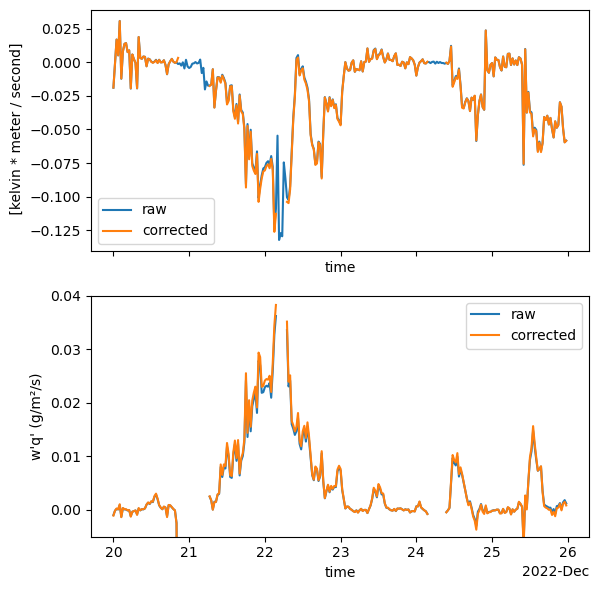

In [96]:
fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize=(6,6))
start = '20221220'
end =   '20221225'
sos_ds['w_tc__3m_c'].loc[start: end].plot(label='raw', ax = ax1)
w_tc__3m_c_corrected.loc[start: end].plot(label='corrected', ax = ax1)
ax1.legend()

sos_ds['w_h2o__3m_c'].loc[start: end].plot(label='raw', ax = ax2)
w_h2o__3m_c_corrected.loc[start: end].plot(label='corrected', ax = ax2)
ax2.legend()
ax2.set_ylim(-0.005,0.04)
ax2.set_ylabel("w'q' (g/m²/s)")

plt.tight_layout()

Text(0, 0.5, "Cumulative w'q' (g/m²)")

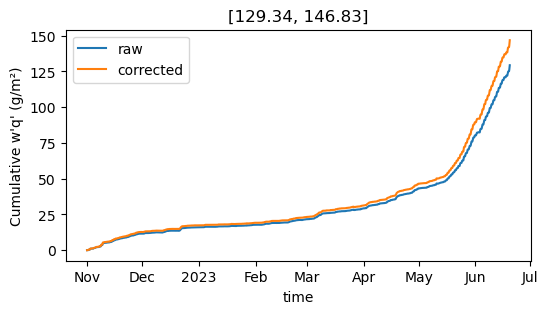

In [97]:
(sos_ds['w_h2o__3m_c'].cumsum()*1.8).plot(label='raw', figsize=(6,3))
(w_h2o__3m_c_corrected.cumsum()*1.8).plot(label='corrected')
plt.title([
    round((sos_ds['w_h2o__3m_c'].cumsum()*1.8)[-1].item(), 2),
    round((w_h2o__3m_c_corrected.cumsum()*1.8)[-1].item().magnitude.item(), 2),
])
plt.legend()
plt.ylabel("Cumulative w'q' (g/m²)")

In [98]:
original_ds = xr.open_dataset("sos_ds_temp_storage_30min_straightup.cdf")

Add back attributes from the original sos datasets to the new, augmented sos dataset

In [99]:
for var in sos_ds:
    if var in original_ds:
        sos_ds[var].attrs = original_ds[var].attrs

In [100]:
sos_ds.to_netcdf("sos_full_dataset_30min.nc")

# Get Tidy Dataset

In [101]:
from sublimpy import tidy

In [102]:
tidy_df = tidy.get_tidy_dataset(sos_ds, list(sos_ds.data_vars))

In [103]:
tidy_df.time.min(), tidy_df.time.max()

(Timestamp('2022-11-01 00:00:00'), Timestamp('2023-06-19 17:30:00'))

Which variables did not get a "measurement" name assigned?

In [104]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

array(['Rpile_out_9m_d', 'Tcase_out_9m_d', 'Rpile_in_9m_d',
       'Tcase_in_9m_d', 'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
       'Tsurfdryairdensity_c'], dtype=object)

In [105]:
set(tidy_df.variable.unique()).difference(set(list(sos_ds.data_vars)))

set()

In [106]:
# import pandas as pd
# import altair as alt
# seconds_in_timestep = 60*30
# density_water = 1000
# from sublimpy import utils
# tidy_df_localized = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# tidy_df_localized = tidy_df_localized[
#     (tidy_df_localized.time > STUDY_PERIOD_START_DATE)
#     &
#     (tidy_df_localized.time < '20230509')
# ]

# measured_results_mm = tidy_df_localized[tidy_df_localized.variable.isin([
#     'w_h2o__2m_c',
#     'w_h2o__3m_c',
#     'w_h2o__5m_c',
#     'w_h2o__10m_c',
#     'w_h2o__15m_c',
#     'w_h2o__20m_c',

#     'w_h2o__3m_ue',
#     'w_h2o__10m_ue',

#     'w_h2o__3m_uw',
#     'w_h2o__10m_uw',

#     'w_h2o__3m_d',
#     'w_h2o__10m_d',
# ])][
#     ['time', 'value', 'variable']
# ]
# measured_results_mm.columns = ['time', 'measured', 'variable']
# measured_results_mm = measured_results_mm.pivot(
#     index = 'time',
#     columns = 'variable',
#     values = 'measured'
# )
# # convert to mm
# measured_results_mm = measured_results_mm*seconds_in_timestep/density_water
# measured_results_cumsum = measured_results_mm.cumsum().reset_index()
# measured_results_cumsum = measured_results_cumsum.melt(id_vars='time')
# measured_results_cumsum['height'] = measured_results_cumsum['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
# measured_results_cumsum['tower'] = measured_results_cumsum['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
# measured_results_cumsum['tower-height'] = measured_results_cumsum['tower'] + '-' + measured_results_cumsum['height'].astype('str')
# measured_results_cumsum


# src = measured_results_cumsum.groupby(['height', 'tower'])[['value']].max().reset_index()
# sublimation_totals_per_height_tower_chart = alt.Chart(src).mark_point(size=100).encode(
#     alt.Y("height:O").sort('-y').title("height (m)"),
#     alt.X("value:Q").scale(zero=False).title(["Seasonal sublimation (mm SWE)"]),
#     # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
#     alt.Shape("tower:N")
# ).properties(width = 150, height = 150)
# sublimation_totals_per_height_tower_chart

# Apply mean diurnal cycle gap filling for latent heat fluxes

In [107]:
print("variable,n_nans_before,total_sub_before,n_nans_after,total_sub_after")
for lhflux_variable in [
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
    'w_h2o__3m_ue',
    'w_h2o__10m_ue',
    'w_h2o__3m_uw',
    'w_h2o__10m_uw',
    'w_h2o__3m_d',
    'w_h2o__10m_d',
]:
    subset = tidy_df[tidy_df.variable == lhflux_variable].set_index('time')
    n_nans_before = subset['value'].isna().sum()
    total_sub_before = (subset['value']*30*60/1000).sum()    
    for i,row in subset.iterrows():
        if np.isnan(row['value']):
            start_window = i - dt.timedelta(days=3, hours=12)
            end_window = i + dt.timedelta(days=3, hours=12)
            src = subset.loc[start_window: end_window].reset_index()
            means = pd.DataFrame(
                src.groupby([src.time.dt.hour, src.time.dt.minute])['value'].mean()
            )
            subset.loc[i, 'value'] = means.loc[i.hour, i.minute].value
    new_values = subset['value'].values
    measurement = subset['measurement'].values[0]
    height = subset['height'].values[0]
    tower = subset['tower'].values[0]
    # Add new values for variable
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        new_values,
        lhflux_variable + '_gapfill',
        measurement,
        height,
        tower
    )
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].isna().sum()
    n_nans_after = subset['value'].isna().sum()
    total_sub_after = (subset['value']*30*60/1000).sum()
    print(lhflux_variable, n_nans_before, round(total_sub_before,1), n_nans_after, round(total_sub_after,1))

variable,n_nans_before,total_sub_before,n_nans_after,total_sub_after
w_h2o__2m_c 809 125.1 0 130.2
w_h2o__3m_c 833 129.3 0 136.1
w_h2o__5m_c 1185 126.9 0 139.7
w_h2o__10m_c 615 144.3 0 150.2
w_h2o__15m_c 794 66.8 0 96.4
w_h2o__20m_c 889 103.8 0 114.2
w_h2o__3m_ue 1127 127.7 0 136.7
w_h2o__10m_ue 929 125.7 0 130.3
w_h2o__3m_uw 1074 130.6 0 138.3
w_h2o__10m_uw 1267 125.9 0 137.3
w_h2o__3m_d 1155 130.3 0 137.4
w_h2o__10m_d 1018 128.6 0 135.6


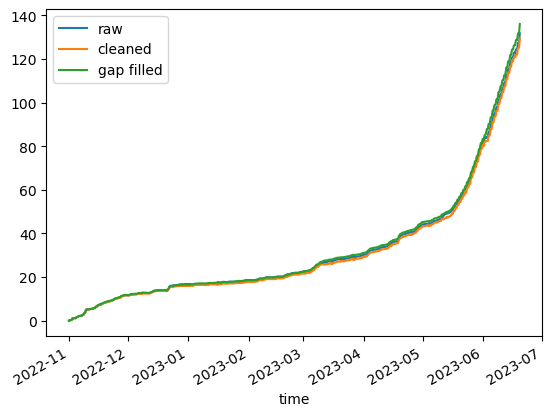

In [108]:
(1.8*tidy_df.query("variable == 'w_h2o__3m_c_raw'").set_index('time').value).cumsum().plot(label='raw')
(1.8*tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').value).cumsum().plot(label='cleaned')
(1.8*tidy_df.query("variable == 'w_h2o__3m_c_gapfill'").set_index('time').value).cumsum().plot(label='gap filled')
plt.legend()

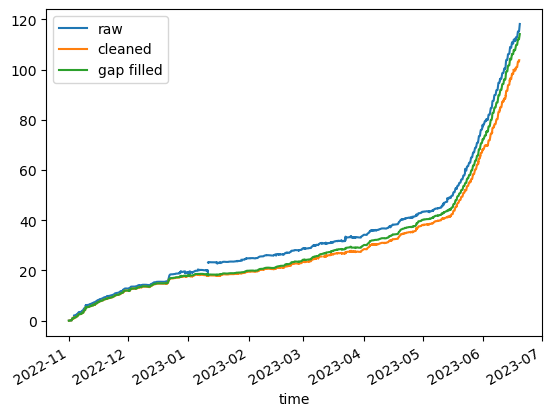

In [109]:
(1.8*tidy_df.query("variable == 'w_h2o__20m_c_raw'").set_index('time').value).cumsum().plot(label='raw')
(1.8*tidy_df.query("variable == 'w_h2o__20m_c'").set_index('time').value).cumsum().plot(label='cleaned')
(1.8*tidy_df.query("variable == 'w_h2o__20m_c_gapfill'").set_index('time').value).cumsum().plot(label='gap filled')
plt.legend()

In [110]:
# import pandas as pd
# import altair as alt
# seconds_in_timestep = 60*30
# density_water = 1000
# from sublimpy import utils
# tidy_df_localized = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# tidy_df_localized = tidy_df_localized[
#     (tidy_df_localized.time > STUDY_PERIOD_START_DATE)
#     &
#     (tidy_df_localized.time < '20230509')
# ]

# measured_results_mm = tidy_df_localized[tidy_df_localized.variable.isin([
#     'w_h2o__2m_c',
#     'w_h2o__3m_c',
#     'w_h2o__5m_c',
#     'w_h2o__10m_c',
#     'w_h2o__15m_c',
#     'w_h2o__20m_c',

#     'w_h2o__3m_ue',
#     'w_h2o__10m_ue',

#     'w_h2o__3m_uw',
#     'w_h2o__10m_uw',

#     'w_h2o__3m_d',
#     'w_h2o__10m_d',
# ])][
#     ['time', 'value', 'variable']
# ]
# measured_results_mm.columns = ['time', 'measured', 'variable']
# measured_results_mm = measured_results_mm.pivot(
#     index = 'time',
#     columns = 'variable',
#     values = 'measured'
# )
# # convert to mm
# measured_results_mm = measured_results_mm*seconds_in_timestep/density_water
# measured_results_cumsum = measured_results_mm.cumsum().reset_index()
# measured_results_cumsum = measured_results_cumsum.melt(id_vars='time')
# measured_results_cumsum['height'] = measured_results_cumsum['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
# measured_results_cumsum['tower'] = measured_results_cumsum['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
# measured_results_cumsum['tower-height'] = measured_results_cumsum['tower'] + '-' + measured_results_cumsum['height'].astype('str')
# measured_results_cumsum


# src = measured_results_cumsum.groupby(['height', 'tower'])[['value']].max().reset_index()
# sublimation_totals_per_height_tower_chart = alt.Chart(src).mark_point(size=100).encode(
#     alt.Y("height:O").sort('-y').title("height (m)"),
#     alt.X("value:Q").scale(zero=False).title(["Seasonal sublimation (mm SWE)"]),
#     # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
#     alt.Shape("tower:N")
# ).properties(width = 150, height = 150)
# sublimation_totals_per_height_tower_chart

In [111]:
# for lhflux_variable in [
#     'w_h2o__2m_c_gapfill',
#     'w_h2o__3m_c_gapfill',
#     'w_h2o__5m_c_gapfill',
#     'w_h2o__10m_c_gapfill',
#     'w_h2o__15m_c_gapfill',
#     'w_h2o__20m_c_gapfill',
#     'w_h2o__3m_ue_gapfill',
#     'w_h2o__10m_ue_gapfill',
#     'w_h2o__3m_uw_gapfill',
#     'w_h2o__10m_uw_gapfill',
#     'w_h2o__3m_d_gapfill',
#     'w_h2o__10m_d_gapfill',
# ]:
#     subset = tidy_df[tidy_df.variable == lhflux_variable].set_index('time')
#     subset = utils.modify_df_timezone(subset.reset_index(), 'UTC', 'US/Mountain').set_index('time')
#     subset = subset.sort_index().loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]
#     subset.value = (subset.value * 1.8).cumsum()
#     subset = subset.reset_index()
#     cumsum_chart = alt.Chart(subset).mark_line().encode(
#         alt.X('time:T'),
#         alt.Y('value:Q').title(subset.variable.iloc[0])
#     ).properties(width=800).configure_axis(titleFontSize=16)
#     display(cumsum_chart)

In [112]:
# src = tidy_df[tidy_df.variable.isin([    
#     'w_h2o__2m_c_raw',
#     'w_h2o__3m_c_raw',
#     'w_h2o__5m_c_raw',
#     'w_h2o__10m_c_raw',
#     'w_h2o__15m_c_raw',
#     'w_h2o__20m_c_raw',
#     'w_h2o__3m_ue_raw',
#     'w_h2o__10m_ue_raw',
#     'w_h2o__3m_uw_raw',
#     'w_h2o__10m_uw_raw',
#     'w_h2o__3m_d_raw',
#     'w_h2o__10m_d_raw'])]
# src = src[(src.time >= '20221221 1200') & (src.time < '20221223')]
# alt.Chart(src).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Color('height:O'),
#     alt.StrokeDash('tower:N')
# )

In [113]:
# src = tidy_df[tidy_df.variable.isin([    
#     'w_h2o__2m_c_raw',
#     'w_h2o__3m_c_raw',
#     'w_h2o__5m_c_raw',
#     'w_h2o__10m_c_raw',
#     'w_h2o__15m_c_raw',
#     'w_h2o__20m_c_raw',
#     'w_h2o__3m_ue_raw',
#     'w_h2o__10m_ue_raw',
#     'w_h2o__3m_uw_raw',
#     'w_h2o__10m_uw_raw',
#     'w_h2o__3m_d_raw',
#     'w_h2o__10m_d_raw'])]
# src = src[(src.time >= '20230505') & (src.time < '20230506')]
# alt.Chart(src).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Color('height:O').scale(scheme='turbo'),
#     alt.StrokeDash('tower:N')
# )

In [114]:
# src = tidy_df.query("measurement == 'w'").query("height > 1").query(
#     "variable != 'w_2m_uw'"
# ).query(
#     "variable != 'w_2_5m_uw'"
# ).query(
#     "variable != 'w_2m_d'"
# ).query(
#     "variable != 'w_2m_ue'"
# )
# src = src[(src.time >= '20230505') & (src.time < '20230506')]
# alt.Chart(src).transform_window(
#     rolling_median = 'mean(value)',
#     frame = [-2, 2],
#     groupby=['height', 'tower']
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('rolling_median:Q'),
#     alt.Color('height:O').scale(scheme='turbo'),
#     alt.StrokeDash('tower:N')
# ).properties(height = 150)

# Save dataset

In [115]:
ls -lah | grep parquet

-rw-r--r--@    1 elischwat  staff    65M Dec 19 23:09 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags360.parquet
-rw-r--r--@    1 elischwat  staff    66M Jan  2 13:10 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000.parquet
-rw-r--r--@    1 elischwat  staff    64M Nov 20 09:49 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_ARCHIVE.parquet


## Create file name based on processing choices

In [116]:
STUDY_PERIOD_START_DATE, STUDY_PERIOD_END_DATE

('20221101', '20230619')

In [117]:
output_filename = None
if PLANAR_FIT:    
    if 'oneplane' in planar_fitted_dir:
        if FILTER_SNOWFALL:
            output_filename = f'tidy_df_{STUDY_PERIOD_START_DATE}_{STUDY_PERIOD_END_DATE}_planar_fit_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}_snowfallfiltered{snowfall_mask_str}.parquet'
        else:
            output_filename = f'tidy_df_{STUDY_PERIOD_START_DATE}_{STUDY_PERIOD_END_DATE}_planar_fit_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}.parquet'
                
    else:
        if FILTER_SNOWFALL:
            output_filename = f'tidy_df_{STUDY_PERIOD_START_DATE}_{STUDY_PERIOD_END_DATE}_planar_fit_multiplane_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}_snowfallfiltered{snowfall_mask_str}.parquet'
        else:
            output_filename = f'tidy_df_{STUDY_PERIOD_START_DATE}_{STUDY_PERIOD_END_DATE}_planar_fit_multiplane_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}.parquet'
else:
    if FILTER_SNOWFALL:
        output_filename = f'tidy_df_{STUDY_PERIOD_START_DATE}_{STUDY_PERIOD_END_DATE}_noplanar_fit_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}_snowfallfiltered{snowfall_mask_str}.parquet',    
    else:
        output_filename = f'tidy_df_{STUDY_PERIOD_START_DATE}_{STUDY_PERIOD_END_DATE}_noplanar_fit_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}.parquet'
output_filename

'tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000.parquet'

## Go back to UTC timezone

In [118]:
from sublimpy import utils

In [119]:
tidy_df = tidy_df[tidy_df.time > '20221107']

In [120]:
tidy_df = utils.modify_df_timezone(tidy_df, 'US/Mountain', 'UTC')

In [121]:
# output_filename = output_filename.replace('.parquet', '_doublerotation.parquet')
output_filename = output_filename.replace('.parquet', '_pf10.parquet')
output_filename

'tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet'

In [125]:
ls | grep parquet

tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags360.parquet
tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000.parquet
tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_ARCHIVE.parquet
tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet


In [123]:
print(output_filename)

tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet


In [124]:
tidy_df.to_parquet(output_filename, index=False)

In [ ]:
ls -lah | grep parquet

In [ ]:
pd.read_parquet(
    "tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_nodespiking_flags36000.parquet"
).query("variable == 'w_h2o__20m_c'").set_index('time')['value'].value_counts()

In [ ]:
pd.read_parquet(
    "tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_nodespiking_flags36000_snowfallfiltered0mm.parquet"
).query("variable == 'w_h2o__20m_c'").set_index('time')['value'].value_counts()

In [ ]:
# sos_ds['w_h2o__3m_c'].loc['20221221':'20221223'].plot(label='w_h2o__3m_c')
# sos_ds['w_h2o__5m_c'].loc['20221221':'20221223'].plot(label='w_h2o__5m_c')
# sos_ds['w_h2o__10m_c'].loc['20221221':'20221223'].plot(label='w_h2o__10m_c')
# sos_ds['w_h2o__15m_c'].loc['20221221':'20221223'].plot(label='w_h2o__15m_c')
# sos_ds['w_h2o__20m_c'].loc['20221221':'20221223'].plot(label='w_h2o__20m_c')
# plt.legend()

In [ ]:
# ls -lah | grep parquet

In [ ]:
# df1 = pd.read_parquet('tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP.parquet')
# df2 = pd.read_parquet('tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_dispiked.parquet')

In [ ]:
# src1 = df1[
#     ~df1.variable.str.contains('predicted')
# ].query("measurement == 'w_h2o_'").query("tower == 'c'").query("height > 1")

# src2 = df2[
#     ~df2.variable.str.contains('predicted')
# ].query("measurement == 'w_h2o_'").query("tower == 'c'").query("height > 1")

In [ ]:
# alt.Chart(
#     src1[src1.time < '20221222'][src1.time > '20221220']
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Color('height:O')
# ) | alt.Chart(
#     src2[src2.time < '20221222'][src2.time > '20221220']
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Color('height:O')
# ).interactive()

# TEST DESPIKING DIFFERENCES

In [ ]:
# import glob
# COLUMNS = [
#     'w_h2o__2m_c_fit', 'w_h2o__3m_c_fit', 'w_h2o__5m_c_fit', 'w_h2o__10m_c_fit', 'w_h2o__15m_c_fit', 'w_h2o__20m_c_fit',
#     'w_h2o__3m_d_fit', 'w_h2o__10m_d_fit',
#     'w_h2o__3m_ue_fit', 'w_h2o__10m_ue_fit',
#     'w_h2o__3m_uw_fit', 'w_h2o__10m_uw_fit',
# ]
# srcq3 = pd.read_parquet(glob.glob("/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_30min_despiked_q3.5/**.parquet"), columns=COLUMNS).sort_index()
# srcq7 = pd.read_parquet(glob.glob("/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_30min_despiked_q7/**.parquet"), columns=COLUMNS).sort_index()
# srcraw = pd.read_parquet(glob.glob("/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_30min/**.parquet"), columns=COLUMNS).sort_index()

# def organize_processed_lhflux_datasets(planar_fitted_data_df): 
#     planar_fitted_data_df = planar_fitted_data_df[[c for c in planar_fitted_data_df.columns if c.endswith('_fit')]]
#     planar_fitted_data_df.columns = [c.replace('_fit', '') for c in planar_fitted_data_df.columns]
#     planar_fitted_data_df.index = planar_fitted_data_df.index - dt.timedelta(minutes=15)
#     return planar_fitted_data_df

# srcq3 = organize_processed_lhflux_datasets(srcq3).assign(processing = 'q3')
# srcq7 = organize_processed_lhflux_datasets(srcq7).assign(processing = 'q7')
# srcraw = organize_processed_lhflux_datasets(srcraw).assign(processing = 'raw')
# src = pd.concat([srcq3, srcq7, srcraw])

# # src = utils.modify_df_timezone(src.reset_index('time'), 'UTC', 'US/Mountain').set_index('time')

In [ ]:
# print(srcraw.index.max(), srcraw.index.min())
# print(srcq7.index.max(), srcq7.index.min())
# print(srcq3.index.max(), srcq3.index.min())

In [ ]:
# print(round(srcraw['w_h2o__10m_d'].mean(), 5), round(srcraw['w_h2o__10m_d'].min(), 5), round(srcraw['w_h2o__10m_d'].max(), 5))
# print(round(srcq7['w_h2o__10m_d'].mean(), 5), round(srcq7['w_h2o__10m_d'].min(), 5), round(srcq7['w_h2o__10m_d'].max(), 5))
# print(round(srcq3['w_h2o__10m_d'].mean(), 5), round(srcq3['w_h2o__10m_d'].min(), 5), round(srcq3['w_h2o__10m_d'].max(), 5))

In [ ]:
# local = src.copy()
# vars = [C.replace('_fit', '') for C in COLUMNS]
# local = local.sort_index().loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]
# local[vars] = local.groupby('processing')[vars].cumsum()
# alt.Chart(
#     local.reset_index()
# ).transform_fold(
#     vars
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Row('key:N'),
#     alt.Color('processing').sort(['raw', 'q7', 'q3'])
# ).properties(width=600, height = 200).resolve_scale(x='independent').interactive()

In [ ]:
# local = src.copy()
# vars = [C.replace('_fit', '') for C in COLUMNS]
# local = local.loc['20221221': '20221222']
# alt.Chart(
#     local.reset_index()
# ).transform_fold(
#     vars
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Row('key:N'),
#     alt.Color('processing').sort(['raw', 'q7', 'q3'])
# ).properties(width=600, height = 200).interactive()

In [ ]:
# local = src.copy()
# vars = [C.replace('_fit', '') for C in COLUMNS]
# local = local.loc['20230110': '20230112']
# alt.Chart(
#     local.reset_index()
# ).transform_fold(
#     vars
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Row('key:N'),
#     alt.Color('processing').sort(['raw', 'q7', 'q3'])
# ).properties(width=600, height = 200).interactive()

In [ ]:
# srcq3 = srcq3.sort_index().loc[:srcq3.index.max()]
# srcq7 = srcq7.sort_index().loc[:srcq3.index.max()]
# srcraw = srcraw.sort_index().loc[:srcq3.index.max()]


In [ ]:
# seconds_in_timestep = 60*30
# density_water = 1000
# # convert to mm
# def convert_to_mm_cumsum(src):
#     measured_results_mm = src.drop(columns='processing')*seconds_in_timestep/density_water
#     measured_results_cumsum = measured_results_mm.cumsum().reset_index()
#     measured_results_cumsum = measured_results_cumsum.melt(id_vars='time')
#     measured_results_cumsum['height'] = measured_results_cumsum['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
#     measured_results_cumsum['tower'] = measured_results_cumsum['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
#     measured_results_cumsum['tower-height'] = measured_results_cumsum['tower'] + '-' + measured_results_cumsum['height'].astype('str')
#     return measured_results_cumsum

# measured_results_cumsum_q3 = convert_to_mm_cumsum(srcq3.loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]).groupby(['height', 'tower'])[['value']].max().reset_index()
# measured_results_cumsum_q7 = convert_to_mm_cumsum(srcq7.loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]).groupby(['height', 'tower'])[['value']].max().reset_index()
# measured_results_cumsum_raw = convert_to_mm_cumsum(srcraw.loc[STUDY_PERIOD_START_DATE: STUDY_PERIOD_END_DATE]).groupby(['height', 'tower'])[['value']].max().reset_index()

In [ ]:
# def seasonal_total_chart(src):
#     return alt.Chart(src).mark_point(size=100).encode(
#         alt.Y("height:O").sort('-y').title("height (m)"),
#         alt.X("value:Q").scale(zero=False).title(["Seasonal sublimation (mm SWE)"]),
#         # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
#         alt.Shape("tower:N")
#     ).properties(width = 200, height = 100)

# (
# seasonal_total_chart(measured_results_cumsum_q3).properties(title='Despiked (q = 3, strict)') &\
# seasonal_total_chart(measured_results_cumsum_q7).properties(title='Despiked (q = 7, standard)') &\
# seasonal_total_chart(measured_results_cumsum_raw).properties(title='Raw, (no despiking)')
# ).resolve_scale(y='shared', x='shared')